In [1]:
#AL May 2016: post-Born calculations for arXiv:1605.05662 (independent of GP Julia code)
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
sys.path.insert(0,r'c:\work\dist\git\camb\pycamb')

import camb
import numpy as np
from camb import model, initialpower
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
from scipy import optimize
from matplotlib import rcParams
from camb.bispectrum import threej
oldparams = rcParams

def setPlotStyle():
    params = {'backend': 'pdf',
              'axes.labelsize': 13,
              'font.size': 11,
              'legend.fontsize': 11,
              'xtick.labelsize': 12,
              'ytick.labelsize': 12,
              'ytick.major.pad': 4,
              'xtick.major.pad': 6,
              'text.usetex': False}
    rcParams.update(params)

FisherResults={}
save_files = False

In [2]:
#Get matter power spectrum interpolation objects for fiducial model
kmax=100
lmax=20000
acc=2 #(change back to 1 unless you need high accuracy - much faster)
nz = 200*acc
nz_bi=200*acc
pars = camb.CAMBparams()
tag=''   
if False: # Giulio
    pars.set_cosmology(H0=67, tau=0.0925, num_massive_neutrinos=0, mnu=0, YHe=0.24)
    pars.InitPower.set_params(ns=0.96, As=2.1265e-9)
    pars.omegab=0.05
    pars.omegac=0.27
    pars.omegav=0.68
    tag='Giulio_'
else:
    pars.set_cosmology(H0=67.0, ombh2=0.022, omch2=0.122)
    pars.InitPower.set_params(ns=0.965)
NL=True
results= camb.get_background(pars)

if True:
    ztag = 'star'
    chistar = results.conformal_time(0)- model.tau_maxvis.value
else:
    #Just for comparing to lower-redshift lensing
    zsource =5
    ztag = '%s'%zsource
    chistar = results.conformal_time(0)-results.conformal_time(zsource)
zmax = results.redshift_at_comoving_radial_distance(chistar)
k_per_logint = None
Pdelta = camb.get_matter_power_interpolator(pars, nonlinear=NL, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=k_per_logint,
    var1=model.Transfer_cdm,var2=model.Transfer_cdm, zmax=zmax)

PKlin, PKlin_z, PKlin_k = camb.get_matter_power_interpolator(pars, nonlinear=False, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=k_per_logint,
    var1=model.Transfer_nonu,var2=model.Transfer_nonu, zmax=zmax, return_z_k=True)
PK = camb.get_matter_power_interpolator(pars, nonlinear=NL, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=k_per_logint,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zmax)

PKX = camb.get_matter_power_interpolator(pars, nonlinear=NL,                                          
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=k_per_logint,
    var1=model.Transfer_tot,var2=model.Transfer_Weyl, zmax=zmax)
print pars

WantCls = 1
WantTransfer = 0
WantScalars = 1
WantTensors = 0
WantVectors = 0
DoLensing = 1
want_zstar = 0
want_zdrag = 0
PK_WantTransfer = 0
NonLinear = 0
Want_CMB = 1
max_l = 2500
max_l_tensor = 600
max_eta_k = 5000.0
max_eta_k_tensor = 1200.0
omegab = 0.0490086879038
omegac = 0.271775451103
omegav = 0.677778694828
omegan = 0.00143716616516
H0 = 67.0
TCMB = 2.7255
YHe = 0.245223829794
num_nu_massless = 2.03066666667
num_nu_massive = 1
nu_mass_eigenstates = 1
share_delta_neff = 0
nu_mass_degeneracies = [1.0153333333333332, 0.0, 0.0, 0.0, 0.0]
nu_mass_fractions = [1.0, 0.0, 0.0, 0.0, 0.0]
nu_mass_numbers = [1, 0, 0, 0, 0]
scalar_initial_condition = 1
OutputNormalization = 1
AccuratePolarization = 1
AccurateBB = 0
AccurateReionization = 0
MassiveNuMethod = 3
InitPower:
  tensor_parameterization = 2
  nn = 1
  an = [0.965, 1.0, 1.0, 1.0, 1.0]
  n_run = [0.0, 0.0, 0.0, 0.0, 0.0]
  n_runrun = [0.0, 0.0, 0.0, 0.0, 0.0]
  ant = [0.0, 0.0, 0.0, 0.0, 0.0]
  nt_run = [-0.0, 0.0, 0.0, 0.0, 0.0]
 

In [3]:
#sampling in L
lsall = np.arange(2,lmax+1, dtype=np.float64)
ls = np.hstack((np.arange(2, 400, 1),np.arange(401, 2600, 10//acc),np.arange(2650, lmax, 50//acc),np.arange(lmax,lmax+1))).astype(np.float64)


Define Limber-approximated linear convergence spectrum for sources at $\chi_1$ and $\chi_2$ (with $\chi_1<\chi_2$):
$$
C_l^\kappa(\chi_1,\chi_2) = l^4 \int_0^{\chi_1} d\chi' \frac{W(\chi',\chi_1)W(\chi',\chi_2)}{(\chi')^2} P_\Psi\left(\frac{l}{\chi'},z(\chi')\right)
$$


In [4]:
#leading order convergence power. 
#Use zeroth order Limber here for consistency (l^2, not l(l+1))
def cl_kappa(chi_source, chi_source2=None):
    chi_source = np.float64(chi_source)
    if chi_source2 is None: 
        chi_source2 = chi_source
    else:
        chi_source2 = np.float64(chi_source2)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = (1/chis-1/chi_source)*(1/chis-1/chi_source2)/chis**2
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PK.P(zs, k, grid=False)*win/k**4)
    cl*= ls**4 #(ls*(ls+1))**2
    return cl

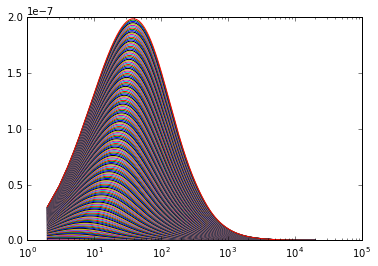

In [5]:
#get grid of C_L(chi_s,k) for different redshifts
nchimax = 100*acc
chimaxs=np.linspace(0 ,chistar, nchimax)
cls = np.zeros((nchimax,ls.size))
for i, chimax in enumerate(chimaxs[1:]):
    cl = cl_kappa(chimax)
    cls[i+1,:] = cl
    plt.semilogx(ls,cl)
cls[0,:]=0    

In [6]:
cl_chi = RectBivariateSpline(chimaxs,ls,cls)

In [7]:
#fiducial C_L for CMB source
clf = cl_chi(chistar, ls, grid=False)
clfall = cl_chi(chistar, lsall, grid=False)


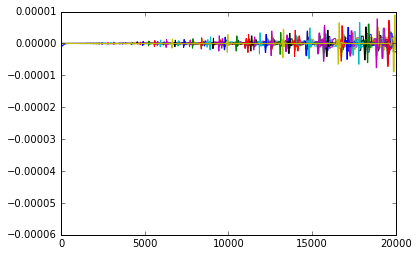

In [8]:
#check interpolation accuracy
for chi in ((chimaxs[1:]+chimaxs[0:-1])/2)[0::10]:
    c1=cl_chi(chi,ls,grid=False)
    c2=cl_kappa(chi)
    plt.plot(ls,(c1-c2)/clf)

For sources at $\chi_*$ define
$$
M(l,l') \equiv l^4\int_0^{\chi_*}d\chi \frac{W(\chi,\chi_*)^2}{\chi^2} P_\Psi\left(\frac{l}{\chi}, z(\chi)\right) C_{l'}^\kappa(\chi)
$$
(differing by factor of $l^4 (l')^4$ from Krause et al)

In [9]:
#Get M(l,l') matrix
chis = np.linspace(0,chistar, nz, dtype=np.float64)
zs=results.redshift_at_comoving_radial_distance(chis)
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
win = (1/chis-1/chistar)**2/chis**2
cl=np.zeros(ls.shape)
w = np.ones(chis.shape)
cchi = cl_chi(chis,ls, grid=True)
M = np.zeros((ls.size,ls.size))
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl = np.dot(dchis*w*PK.P(zs, k, grid=False)*win/k**4,cchi)
    M[i,:] = cl*l**4 #(l*(l+1))**2


In [10]:
Mf = RectBivariateSpline(ls,ls,np.log(M))
Msp = RectBivariateSpline(ls,ls,M)

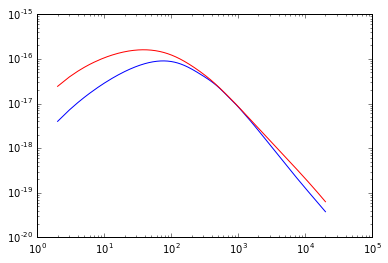

In [11]:
#M for one l fixed looks like kappa, e.g. passably approximated as product of two C_kappa
ll=2000
plt.loglog(ls,Msp(ls,ll))
plt.loglog(ls,cl_chi(chistar, ls, grid=False)*cl_chi(chistar/2., ll, grid=False), color='r');

In [12]:
if False:
    #test functions that can be checked analytically
    import math
    for i,l in enumerate(ls):
        for ii,ll in enumerate(ls):
            M[i,ii]= 10./(l**2+ll**2)

    def Mf(l,ll, grid=False):
         return np.log(10./(l**2+ll**2))

The leading order post-Born correction, defining $\boldsymbol{l}'' = \boldsymbol{l} - \boldsymbol{l}'$, is
$$
\Delta C_l = 4\int \frac{d^2\boldsymbol{l}'}{(2\pi)^2}\left(  \frac{(l\cdot l'')^2(l''\cdot l')^2}{(l'')^4 (l')^4} M(l'',l') - \frac{(l\cdot l')^2}{(l')^4}M(l,l')  \right)
$$
[how do you get rid of the vertical lines??]
Note that for small $l'$, we have $l''\approx l$, so for $l' \ll l$ can do series expansion and integrate analytically and leading contributions from the two terms cancel giving
$$
\frac{1}{8\pi}\int l'dl' \left(  5l\frac{d\ln M(l,l')}{d l} + 3l^2\left[\frac{d^2\ln M(l,l')}{d l^2} +
\left(\frac{d\ln M(l,l')}{d l}\right)^2\right] - 2\right)
M(l,l')
$$
In addition to $l'$ being small, contribution to the same leading order appear from small $l''$:
$$
\frac{1}{8\pi}\int l'dl' 6 M(l',l) 
$$
More generally, to be numerically IR stable at high $l$ Krause et al suggest
$$
\Delta C_l = 4\int \frac{d^2\vec{l}'}{(2\pi)^2}\left(  \frac{(l\cdot l'')^2(l''\cdot l')^2}{(l'')^4 (l')^4}\left( M(l'',l')-\frac{(l'')^4}{l^4}M(l,l') \right) - 
\frac{(l\cdot l')^2l^4 - (l\cdot l'')^2(l'\cdot l'')^2  }{(l')^4l^4}M(l,l')  \right)
$$
Doing the latter angular integral gives
$$
\Delta C_l = 4\int \frac{d^2\vec{l}'}{(2\pi)^2}\left(  \frac{(l\cdot l'')^2(l''\cdot l')^2}{(l'')^4 (l')^4}\left( M(l'',l')-\frac{(l'')^4}{l^4}M(l,l') \right) \right) + \frac{1}{4\pi}\int l'dl'\left(27+\frac{4(l')^2}{l^2} \right) M(l,l')
$$
Note that this is now problematic for $l\ll l'$. So Could split the integration into domain with $l<l'$ and $l\ge l'$ and choose appropriate form. In any case different forms give good cross-check on numerical stability.


In [13]:
#this the l, l' matrix for l' << l, prior to l'dl' integration.
approx=np.zeros(M.shape)
dM = Mf(ls,ls,dx=1, grid=True)
ddM =  Mf(ls,ls,dx=2, grid=True) 
for i, ell in enumerate(ls):
    approx[i,:] = ((5*ell*dM[i,:]-2+3*ell**2*
                    (ddM[i,:] + dM[i,:]**2))*M[i,:])/8./np.pi
approxsp = RectBivariateSpline(ls,ls,approx)    

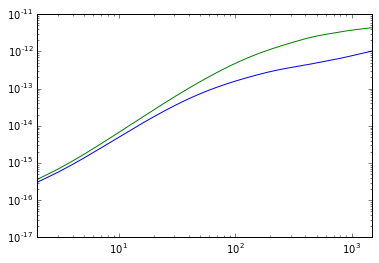

In [14]:
#plot contribution per log l'
ll=1500
lplot = np.arange(2,lmax)
plt.loglog( lplot**2*np.abs(approxsp(ll,lplot,grid=False)))
## including l~l' term, which is much bigger
plt.loglog( lplot**2*np.abs(approxsp(ll,lplot,grid=False) + 6*Msp(lplot,ll,grid=False)/8/np.pi)) 
plt.xlim([2,ll]);


In [15]:
if False: # not sure what to do with this result for l'' < l
    approx_leqs=np.zeros(M.shape)
    dM = Mf(ls,ls,dy=1, grid=True)
    ddM =  Mf(ls,ls,dy=2, grid=True) 
    for i, ell in enumerate(ls):
        approx_leqs[:,i] = (6*M[i,:]+  (16-15*ls*dM[i,:]+5*ls**2*
                        (ddM[i,:] + dM[i,:]**2))*M[i,:]*ell**2/ls**2/2 )/8./np.pi
    #Oscillations here seem real?
    plt.loglog( np.abs(approx_leqs[2000,:]))
    plt.loglog( np.abs(6*M[:,2000]/8/np.pi)) 

In [16]:
#L sampling for output
lsamp = np.hstack((np.arange(2, 20, 2), np.arange(25, 200, 10//acc), np.arange(220, 1200, 30//acc),
                   np.arange(1300, min(lmax//2,2600), 150//acc),np.arange(3000, lmax//2+1, 1000//acc)))
cl1=np.zeros(lsamp.shape)
cl1partial=np.zeros(lsamp.shape)


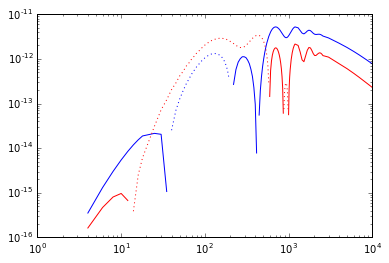

In [17]:
#series result taking all l' < l. Would be good approx if dominated by squeezed shapes (high L) 
#6M term is larger in regime of validity
clapprox = np.zeros(lsamp.shape)
clapprox2 = np.zeros(lsamp.shape)
lplot = np.arange(2,lmax)
for i, ll in enumerate(lsamp):
    lmx =ll/2-2+1
    clapprox[i]=np.dot(approxsp(ll,lplot[:lmx],grid=False),lplot[:lmx])
    clapprox2[i]=np.dot(approxsp(ll,lplot[:lmx],grid=False)+ 6*Msp(lplot[:lmx],ll,grid=False)/8/np.pi,
                        lplot[:lmx])

plt.loglog(lsamp, clapprox, color='r');
plt.loglog(lsamp, clapprox2, color='b');
plt.loglog(lsamp, -clapprox, color='r',ls=':');
plt.loglog(lsamp, -clapprox2, color='b',ls=':');


(2, 1500)

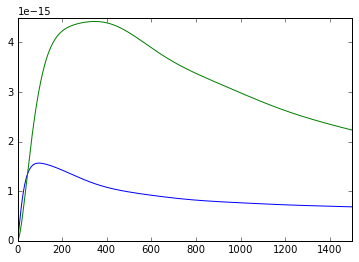

In [18]:
#integrand in l is
ll=1500
plt.plot(ls,ls*approxsp(ll,ls,grid=False))
plt.plot(ls,ls*(6*Msp(ls,ll,grid=False)/8/np.pi))
plt.xlim([2,ll])

In [19]:
#Test routine for one part of integral
def phi_term(ll, llp, lmin=2, fac=1):
    l = np.float64(ll)
    lp = np.float64(llp)
    llp=int(llp)
    ll=int(ll)
    nphi = (2*int(llp*fac)+1)
    dphi= 2*np.pi/nphi
    phi = np.linspace(0, (nphi-1)/2*dphi, (nphi-1)//2+1)
    #phi = np.linspace(-(nphi-1)/2*dphi, (nphi-1)/2*dphi, nphi)   
    w = np.ones(phi.size)
    w[1:] = 2
    cosphi = np.cos(phi)
    lrat = lp/l
    lfact = np.sqrt(1+ lrat**2- 2*cosphi*lrat) 
    lnorm = l*lfact
    w[lnorm < lmin]=0
    w[lnorm > lmax]=0
    lfact[lfact<=0] = 1
    lnorm = np.maximum(lmin, np.minimum(lmax,lnorm))
    em = Msp(l,lp,grid=False)
    t1 = lp*(l/lp)**2*np.dot(w,((1-lrat*cosphi)*(cosphi-lrat))**2*
           np.exp(Mf(lnorm,lp,grid=False))/lfact**4)*dphi
    t2 = lp*(l/lp)**2*np.dot(w,cosphi**2)*em*dphi

    tmp = t1 -t2

    cl2partial = lp*(l/lp)**2*np.dot(w,((1-lrat*cosphi)/lfact**2*(cosphi-lrat))**2*
            (np.exp(Mf(lnorm,lp,grid=False)) - lfact**4*em) )*dphi
    norm =(4/(2*np.pi)**2)
    KrauseApprox = cl2partial*norm + np.sum(w)/nphi*em*lp*(27+4*lp**2/l**2)/4/np.pi
    return tmp*norm, KrauseApprox

#Note only expect same results from KrauseApprox partially analytic for ll+lp<lmax
lp=300
ll=3500
Lseries = int(ll/10)
for fac in [0.1, 1, 10]:
    print phi_term(ll,lp, 2, fac), lp*approxsp(ll, lp) 
#These should all agree up to higher order series terms (and numerical error)


(7.5877157192384017e-16, 7.587715719238235e-16) [[  7.58221535e-16]]
(7.5877157217909929e-16, 7.5877157217909889e-16) [[  7.58221535e-16]]
(7.587715721793039e-16, 7.5877157217932293e-16) [[  7.58221535e-16]]



Note that for $l'\gg l$ we have
$$
\Delta C_l \approx \frac{l^2}{\pi}\int \frac{dl'}{l'} \left\{ M(l',l')-M(l,l') 
+\frac{l^2}{8l'^2} \left(  5l'\frac{d\ln M(l',l')}{d l'} + 3{l'}^2\left[\frac{d^2\ln M(l',l')}{d {l'}^2} +
\left(\frac{d\ln M(l',l')}{d l'}\right)^2\right] - 2\right)
\right\}
$$
where derivatives are w.r.t. the first argument of $M$.

In [20]:
#for integration of high l' tail using series approx
def high_integrand(ll,lp):
    if np.isscalar(lp):
        lp = int(lp)
    else:
        lp = lp.astype(np.int)
    r2= (np.float64(ll)/lp)**2
    return lp*r2*(Msp(lp,lp,grid=False)/np.pi + r2*approxsp(lp,lp,grid=False)  -Msp(ll,lp,grid=False)/np.pi)

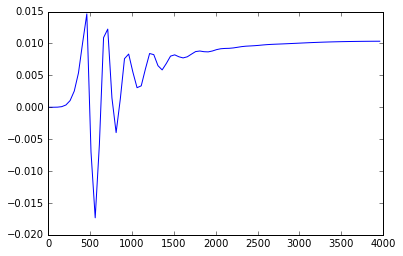

In [21]:
#Compare accuracy for high lp tail integration. Note approx anyway better for lp > lmax-l.
#Go for about 1%
def testAcc():
    acc=[]; lacc=[]
    ltest = np.arange(10,4000,50)
    for ll in ltest:
        lp=int(max(1000,ll*2.2))
        if lmax-ll  < lp: break
        acc.append(high_integrand(ll,lp)/ phi_term(ll,lp, 2, 1)[0] -1)
        lacc.append(ll)
    plt.plot(lacc,acc)
testAcc()

In [22]:
tails = np.zeros(lsamp.shape)
for i,ll in enumerate(lsamp):
    tails[i] = np.sum(high_integrand(ll,lsall[int(ll*2.5)-2:].astype(np.int)))

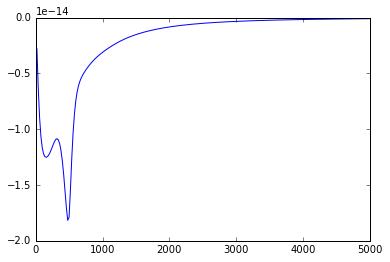

In [23]:
#Look at what l' integrand looks like
def plotInt():
    acc=[]; lacc=[]
    ll=500
    ltest = np.arange(20,5000,20)
    for lp in ltest:
        acc.append(phi_term(ll,lp, 2, 1)[0])
        lacc.append(lp)
    plt.plot(lacc,acc)
    plt.axhline(0,color='k')
plotInt()

In [24]:
#Main function to calculate post-Born convergence power
cl=np.zeros(lsamp.shape)
cl2partial=np.zeros(lsamp.shape)
cl3partial=np.zeros(lsamp.shape)
clseries = np.zeros(lsamp.shape)
clseries2 = np.zeros(lsamp.shape)

#Test function with method variations; probably doesn't work any more
def postbornvars(i,ll):    
    l = np.float64(ll)
    ll=int(ll)
    l2=l**2
    if ll>200:
        # to patch on series result for very squeezed shapes
        Lseries = int(ll/10)
        clseries[i]=np.sum(approx[ll-2,:Lseries-2]*lsall[:Lseries-2])
    else:
        Lseries=0
    lmin = lsall[0]
    lpmax=int(max(1000,l*2.3))
    for llp in lsall[:lpmax-2]:
          lp=np.float64(llp)
          llp = int(llp)
          nphi = 2*int(lp)+1
          dphi= 2*np.pi/nphi
          phi = np.linspace(0, (nphi-1)/2*dphi,  (nphi-1)//2+1)
          w = np.ones(phi.size)
          w[1:] = 2  #function is even, only doing phi<pi
          cosphi = np.cos(phi)
          lrat = lp/l
          lfact = np.sqrt(1+lrat**2-2*cosphi*lrat) 
          lnorm = l*lfact
          w[lnorm < lmin]=0
          w[lnorm > lmax]=0
          lfact[lfact<=0] = 1
          lnorm = np.maximum(lmin, np.minimum(lmax,lnorm))
          tmp = lp*(l/lp)**2*np.dot(w,((1-lrat*cosphi)/lfact**2*(cosphi-lrat))**2*
                    np.exp(Mf(lnorm,lp,grid=False))- cosphi**2*M[ll-2,int(llp)-2])*dphi
          if lp < min(ll,lmax-ll):
              cl2partial[i]+= lp*(l/lp)**2*np.dot(w,((1-lrat*cosphi)/lfact**2*(cosphi-lrat))**2*
                    (np.exp(Mf(lnorm,lp,grid=False)) - lfact**4*M[ll-2,int(llp)-2]) )*dphi
          else:
              cl3partial[i] += tmp
                
          if lp>=Lseries:
              clseries2[i] += tmp
          cl[i]+= tmp
            
            
    cl[i]*=4/(2*np.pi)**2
    cl2partial[i]*=4/(2*np.pi)**2
    cl3partial[i]*=4/(2*np.pi)**2
    clseries2[i]*=4/(2*np.pi)**2
    if lpmax < lmax:
        tail = np.sum(high_integrand(ll,lsall[lpmax-2:].astype(np.int)))
        print cl[i], tail
        cl[i] += tail
        cl3partial[i] += tail
        clseries2[i] += tail

        
#fast version with efficient sampling        
def postborn(i,ll):    
    l = np.float64(ll)
    ll=int(ll)
    l2=l**2
    if ll>200:
        # to patch on series result for very squeezed shapes
        Lseries = int(ll/10)
        clseries[i]=np.sum(approxsp(ll,lsall[:Lseries-2],grid=False)*lsall[:Lseries-2])
    else:
        Lseries=0
    lmin = lsall[0]
    lpmax=min(lmax,int(max(1000,l*2.1)))
    if ll<500:
       lcalc= lsall[max(0,Lseries-2):lpmax-2]
    else:
        #sampling in l', with denser around l~l'
       lcalc = np.hstack((lsall[max(0,Lseries-2):20:4],
                          lsall[max(20,Lseries-2):ll-200:35],
                          lsall[ll-190:ll+210:6],
                          lsall[ll+220:lpmax+60:60] ))
    tmps = np.zeros(lcalc.shape) 
    for ix, llp in enumerate(lcalc):
          lp=np.float64(llp)
          llp = int(llp)
          if abs(ll-llp)>200 and lp>200:
              nphi = 2*int(min(lp/10,200))+1
          elif ll>2000:
              nphi = 2*int(lp/10)+1
          else:
              nphi = 2*int(lp)+1
          dphi= 2*np.pi/nphi
          phi = np.linspace(0, (nphi-1)/2*dphi,  (nphi-1)//2+1)
          w = np.ones(phi.size)
          w[1:] = 2  #function is even, only doing phi<pi
          cosphi = np.cos(phi)
          lrat = lp/l
          lfact = np.sqrt(1+lrat**2-2*cosphi*lrat) 
          lnorm = l*lfact
          w[lnorm < lmin]=0
          w[lnorm > lmax]=0
          lfact[lfact<=0] = 1
          lnorm = np.maximum(lmin, np.minimum(lmax,lnorm))
          tmp = lp*(l/lp)**2*np.dot(w,((1-lrat*cosphi)/lfact**2*(cosphi-lrat))**2*
                    np.exp(Mf(lnorm,lp,grid=False))- cosphi**2*Msp(l,lp,grid=False))*dphi
          tmps[ix] += tmp
    sp = UnivariateSpline(lcalc, tmps, s=0)
    clseries2[i] = sp.integral(max(2,Lseries), lpmax-1)*4/(2*np.pi)**2
           
    if lpmax < lmax:
        tail = np.sum(high_integrand(ll,lsall[lpmax-2:].astype(np.int)))
        #print clseries2[i], tail
        clseries2[i] += tail
    if ll > lmax/10 and ll <= lmax//2:
        #Approximate extrapolation for l'>lmax, fitting power law shape and using integral of A(l/lmax)^index
        dlog=np.log(-high_integrand(ll,np.arange(lmax-100,lmax+1,100)))
        index = (dlog[1]-dlog[0])/np.log(lmax/(lmax-100.))
        clseries2[i]+= lmax/(index+1)*np.exp(dlog[1])
        
if True:
    for i, ll in enumerate(lsamp): 
        postborn(i,ll)
        cl[i]=clseries2[i] + clseries[i]
        print ll, cl[i], clseries[i]
    postborn_direct = cl   
    if save_files:
        np.savetxt(tag+'postborn_kappa_%s_%s_%s_%s_z%s.txt'%(lmax,kmax,nz,nchimax, ztag), 
           np.vstack((lsamp,postborn_direct)).T)
else:
    for i, ll in enumerate(lsamp):
        postbornvars(i,ll)
        print ll, cl[i], cl2partial[i], cl3partial[i], clseries2[i]
    postborn_direct = cl
    postborn_series =  clseries2+clseries
    postborn_krause = (cl1partial+cl2partial+cl3partial)
    if save_files:
        np.savetxt(tag+'postborn2_%s_%s_%s_%s.txt'%(lmax,kmax,nz,nchimax), 
               np.vstack((lsamp,postborn_direct,postborn_krause, postborn_series)).T)


2 2.18758914946e-14 0.0
4 7.56363811038e-14 0.0
6 1.44158407813e-13 0.0
8 2.15541294798e-13 0.0
10 2.81278532573e-13 0.0
12 3.35204802188e-13 0.0
14 3.73950478807e-13 0.0
16 3.91227571724e-13 0.0
18 3.88037325288e-13 0.0
25 1.95042421209e-13 0.0
30 -1.24223426569e-13 0.0
35 -5.78486113788e-13 0.0
40 -1.14979220511e-12 0.0
45 -1.83013096054e-12 0.0
50 -2.59183289965e-12 0.0
55 -3.41812339606e-12 0.0
60 -4.28320049448e-12 0.0
65 -5.17957694862e-12 0.0
70 -6.09103896974e-12 0.0
75 -6.99301463839e-12 0.0
80 -7.88705660508e-12 0.0
85 -8.75098325641e-12 0.0
90 -9.58135441293e-12 0.0
95 -1.03733109938e-11 0.0
100 -1.11159989525e-11 0.0
105 -1.18100328705e-11 0.0
110 -1.24488668103e-11 0.0
115 -1.30325198506e-11 0.0
120 -1.35581435399e-11 0.0
125 -1.40267809756e-11 0.0
130 -1.44374100846e-11 0.0
135 -1.47951210173e-11 0.0
140 -1.51007857374e-11 0.0
145 -1.53557879828e-11 0.0
150 -1.55615816463e-11 0.0
155 -1.57239769195e-11 0.0
160 -1.58434732827e-11 0.0
165 -1.59248893954e-11 0.0
170 -1.59733

(10, 10000.0)

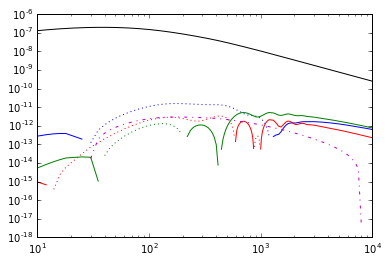

In [25]:
plt.loglog(ls,clf, color='k')
plt.loglog(lsamp, postborn_direct, color='b') #full numerical
#various series approximations. only high-L approx is decent
plt.loglog(lsamp, -postborn_direct, color='b', ls=':');
plt.loglog(lsamp, clapprox, color='r', ls='-');
plt.loglog(lsamp, -clapprox, color='r', ls=':');
plt.loglog(lsamp, clapprox2, color='g');
plt.loglog(lsamp, -clapprox2, color='g', ls=':');

plt.loglog(lsamp,-tails, color='m', ls='-.');

plt.xlim([10,1e4])

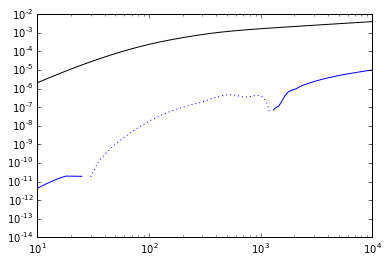

In [26]:
#in L^2 C_L
plt.loglog(ls, ls**2*clf/2/np.pi, color='k')

plt.loglog(lsamp, lsamp**2*postborn_direct/2/np.pi, color='b')
plt.loglog(lsamp, -lsamp**2*postborn_direct/2/np.pi, color='b', ls=':');
plt.xlim([10,1e4]);

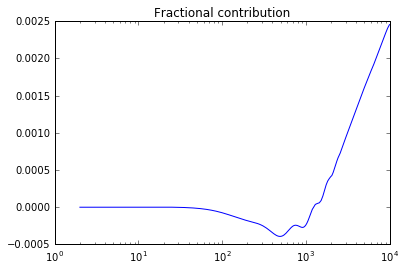

In [27]:
#post-Born effect is tiny..
plt.semilogx(lsamp,postborn_direct/clfall[lsamp.astype(int)-2])
plt.title('Fractional contribution');

Curl spectrum is given by
$$
C_l^{\rm curl} = 4\int \frac{d^2 l'}{(2\pi)^2} \frac{l^4\sin^2\phi(\cos\phi-l'/l)^2}{(l'')^4} M(l',l'') 
$$
Note that although $M$ is not symmetric, the integrand is symmetric under $M(l',l'')\leftrightarrow M(l'',l')$.

In [28]:
#Get rotation (curl) spectrum. Much easier numerically
diagm = np.diag(M)
diagmsp = UnivariateSpline(ls,diagm,s=0)
def high_curl_integrand(ll,lp):
    lp = lp.astype(np.int)
    r2= (np.float64(ll)/lp)**2
    return lp*r2*diagmsp(lp)/np.pi
    
clcurl = np.zeros(lsamp.shape)

for i, ll in enumerate(lsamp):

    l = np.float64(ll)
    l2=l**2
    lmin = lsall[0]
    lpmax=min(lmax,int(max(1000,l*2)))
    if ll<500:
       lcalc= lsall[0:lpmax-2]
    else:
        #sampling in l', with denser around l~l'
       lcalc = np.hstack((lsall[0:20:4],
                          lsall[29:ll-200:35],
                          lsall[ll-190:ll+210:6],
                          lsall[ll+220:lpmax+60:60] ))
    
    tmps = np.zeros(lcalc.shape) 
    for ix,lp in enumerate(lcalc):
          llp=int(lp) 
          lp = np.float64(lp)
          if abs(ll-llp)>200 and lp>200:
              nphi = 2*int(min(lp/10*acc,200))+1
          elif ll>2000:
              nphi = 2*int(lp/10*acc)+1
          else:
              nphi = 2*int(lp)+1
          dphi= 2*np.pi/nphi
          phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2) #even and don't need zero
          w = 2*np.ones(phi.size)
          cosphi = np.cos(phi)
          lrat = lp/l
          lfact = np.sqrt(1+lrat**2- 2*cosphi*lrat) 
          lnorm = l*lfact
          lfact[lfact<=0] = 1
          w[lnorm < lmin]=0
          w[lnorm > lmax]=0
          
          lnorm = np.maximum(lmin, np.minimum(lmax,lnorm))
          tmps[ix]+= lp*np.dot(w,(np.sin(phi)/lfact**2*(cosphi-lrat))**2*
                    np.exp(Mf(lnorm,lp, grid=False)))*dphi
     
    sp = UnivariateSpline(lcalc, tmps, s=0)
    clcurl[i] = sp.integral(2, lpmax-1)*4/(2*np.pi)**2
           
    if lpmax < lmax:
        tail = np.sum(high_curl_integrand(ll,lsall[lpmax-2:]))
        clcurl[i] += tail
           
    #print ll, clcurl[i]
if save_files:
    np.savetxt(tag+'postborn_curl_%s_%s_%s_%s.txt'%(lmax,kmax,nz,nchimax), np.vstack((lsamp,clcurl)).T)

curl power 6.96473307412e-06 0.00263907807276
kappa power 0.0116442526574 0.10790853839


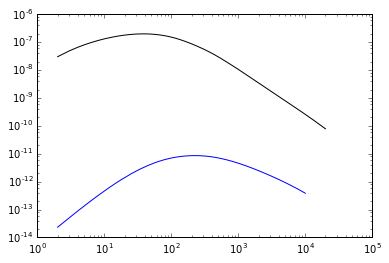

In [29]:
plt.loglog(lsall,clfall, color='k')
plt.loglog(lsamp,clcurl, color='b');
sp = UnivariateSpline(lsamp, (2*lsamp+1)/4/np.pi*clcurl, s=0)
var_curl =  sp.integral(lsamp[0],lsamp[-1])
var_kappa = np.dot(clfall[:lmax-2],(2*lsall[:lmax-2]+1)/4/np.pi)
print 'curl power', var_curl, np.sqrt(var_curl)
print 'kappa power', var_kappa, np.sqrt(var_kappa)

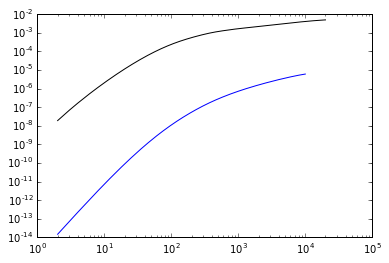

In [30]:
plt.loglog(ls,ls**2*clf/2/np.pi, color='k')
plt.loglog(lsamp,lsamp**2*clcurl/2/np.pi, color='b');

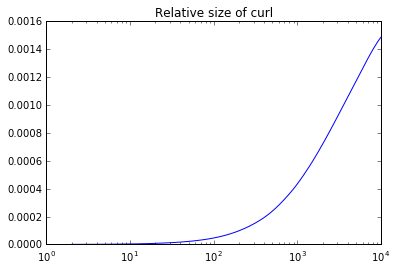

In [31]:
plt.semilogx(lsamp,clcurl/clfall[lsamp.astype(int)-2])
plt.title('Relative size of curl');

In [32]:
#Linear power spectrum
cl=cl_kappa(chistar)
if save_files:
    np.savetxt(tag+'kappa_%s_%s_%s_%s_z%s.txt'%(lmax,kmax,nz,nchimax, ztag), 
           np.vstack((ls,cl)).T)

In [33]:
#Look at B power from curl
#These are standard CAMB outputs
CL = np.loadtxt(r'C:\Work\F90\LensingBiases\base_plikHM_TT_lowTEB_lensing_lenspotentialCls.dat')
Ref= np.loadtxt(r'C:\Work\F90\LensingBiases\base_plikHM_TT_lowTEB_lensing_lensedCls.dat')

In [34]:
CE = np.hstack((np.zeros(2),CL[:,2]/(CL[:,0]*(CL[:,0]+1))*2*np.pi))
CPhi = np.hstack((np.zeros(2),CL[:,5]/4*2*np.pi))
cl_ls = np.hstack((np.arange(2), CL[:,0])).astype(np.int)
print 'lmax cl = ', cl_ls[-1]

lmax cl =  21500


The leading B mode from curl, neglecting $\omega\kappa\kappa$ bispectrum terms, is
$$
C_l^{BB} = 4\int \frac{d^2l'}{(2\pi)^2} \sin^2 \phi_{l'} \sin^2 2\phi_{l'} \frac{l^2{l'}^2}{{l''}^4}C^{\omega\omega}_{l''} C^{EE}_{l'}
$$
(differing from Eq 52 of Hirata&Seljak [their definition of $\alpha$ looks wrong], and factor of two from Cooray and Hu)
For low $l$, this is approximately
$$
C_l^{BB} = \frac{l^2}{2\pi} \int d \ln l' C^{\omega\omega}_{l'} C^{EE}_{l'}
$$
and hence has steeper slope than the gradient B mode. Can be interpreted as because the leading curl B is a total derivative.

In [35]:
CEsp = UnivariateSpline(cl_ls, CE, s=0)
CurlSp = UnivariateSpline(lsamp,clcurl, s=0)
phiSp = UnivariateSpline(cl_ls,CPhi, s=0)

Bcurl = np.zeros(lsamp.shape)
Bcurl2 = np.zeros(lsamp.shape)
Bphi = np.zeros(lsamp.shape)

for i, ll in enumerate(lsamp):
    if ll > cl_ls[-1]//2: break
    l = np.float64(ll)   
    tmps = np.zeros(cl_ls[-1]+1)
    for llp in range(10,cl_ls[-1]):
      lp = np.float64(llp)
      if abs(ll-llp)>200 and lp>200:
          nphi = 2*int(min(lp/10*acc,200))+1
      elif ll>2000:
          nphi = 2*int(lp/10*acc)+1
      else:
          nphi = 2*int(lp)+1
      dphi= 2*np.pi/nphi
      phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2) 
      w = 2*np.ones(phi.size)
      cosphi = np.cos(phi)
      sin2phi = np.sin(2*phi)
      lpp = np.sqrt(lp**2+l**2- 2*cosphi*l*lp) 
      w[lpp < 2]=0
      w[lpp > cl_ls[-1]]=0
      #First one here looks wrong (Hirata and Seljak defined angle wrong)
      #Bcurl[i]+=  np.dot(w, CEsp(lpp) *(lp*l)**2*np.sin(phi)**2*np.sin(2*phi)**2) *dphi * CurlSp(lp)*lp/lp**4
      #Bcurl[i]+=  4*np.dot(w, CEsp(lpp)*np.sin(phi)**4*(l**2-lp*l*cosphi)**2/lpp**4) *dphi * CurlSp(lp)*lp
        
      Bcurl2[i]+=  np.dot(w, CurlSp(lpp)*(lp*l)**2/lpp**4*(np.sin(phi)*sin2phi)**2) *dphi * CEsp(lp)*lp

      tmp =  np.dot(w, phiSp(lpp)/lpp**4*(lp**2-lp*l*cosphi)**2*sin2phi**2) *dphi *CEsp(lp)*lp 
      #tmp =   np.dot(w, CEsp(lpp)*(lp**2-ll*lp*cosphi)**2*np.sin(2*phi)**2) *dphi * CPhi[llp]*lp /lp**4
      tmps[llp] = tmp
      Bphi[i]+= tmp
        
    Bcurl[i]*= 4/(2*np.pi)**2
    Bphi[i]*= 4/(2*np.pi)**2
    Bcurl2[i]*= 4/(2*np.pi)**2

    #print ll, Bcurl2[i],  Bphi[i] 

#For the same spectrum, curl generates slightly more B (agree with 1307.2355 Fig 3), 
#can be checked setting CurlSp=phiSp above

In [36]:
sp = UnivariateSpline(cl_ls[10:],CEsp(cl_ls[10:])*CurlSp(cl_ls[10:])/cl_ls[10:], s=0)
Bapprox = sp.integral(10, lsamp[-1])

In [37]:
pars.InitPower.set_params(ns=0.96, As=pars.InitPower.ScalarPowerAmp[0], r=0.01)
pars.WantTensors=True
cl_tensor01=results.get_cmb_power_spectra(pars,spectra=['tensor'])
BB_tensor=cl_tensor01['tensor'][:,2]

B curl variance, rms = 9.59736620089e-05 0.00979661482395
B kappa variance, rms = 0.179715517388 0.423928670165
Large-scale B convergence power = 1.91677981492e-06
Large-scale B curl power = A (l/100)^2 with A= 1.6644128898e-11


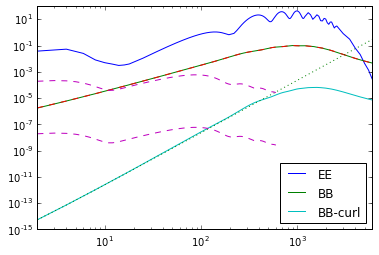

In [38]:
fac=lsamp*(lsamp+1)/2/np.pi
plt.loglog(lsamp,fac*CEsp(lsamp))
plt.loglog(Ref[:,0],Ref[:,3])
#plt.loglog(lsamp,fac*Bcurl,color='r')
plt.loglog(lsamp,fac*Bcurl2, color='c')

plt.loglog(lsamp,fac*Bphi,ls='--')
plt.loglog(lsamp, fac*lsamp**2/2/np.pi*Bapprox,ls=':', color='g') #asymptotic fit
plt.loglog(np.arange(BB_tensor.size), BB_tensor*2.726e6**2,color='m',ls='--')
plt.loglog(np.arange(BB_tensor.size), BB_tensor*2.726e6**2*1e-4,color='m',ls='--')

plt.xlim([10,lsamp[-1]])
plt.legend(['EE','BB','BB-curl'], loc='lower right')
spcurl = UnivariateSpline(lsamp, (2*lsamp+1)/4/np.pi*Bcurl2, s=0)
var_B_curl =  spcurl.integral(lsamp[0],lsamp[-1])
print 'B curl variance, rms =', var_B_curl, np.sqrt(var_B_curl)
sp = UnivariateSpline(lsamp, (2*lsamp+1)/4/np.pi*Bphi, s=0)
var_B_kappa =  sp.integral(lsamp[0],lsamp[-1])
print 'B kappa variance, rms =', var_B_kappa, np.sqrt(var_B_kappa)
print 'Large-scale B convergence power = %s'%Bphi[3]
print 'Large-scale B curl power = A (l/%s)^2 with A='%100, spcurl(100)*4*np.pi/(2*100+1)
if save_files:
    np.savetxt('Bmodes.dat' , np.vstack((lsamp,Bphi, Bcurl2)).T)
plt.xlim([2, 6000]);

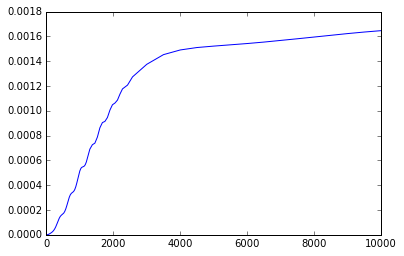

In [39]:
plt.plot(lsamp,Bcurl2/Bphi)

In [40]:
pb_sp=UnivariateSpline(lsamp,postborn_direct, s=0)

In [41]:
#Look at Fisher, assuming quadratic delensing and simplistic assumptions
#naive N0 without delensing
i_TT=0
i_EE=1
i_EB=2
i_TE=3
i_TB=4
i_BB=5
noisetags =['S4_Noise1_Beam3','planck','SA','SPT3G','Noise0.25_Beam1' ]
fskies = {'SA':0.65,'planck':0.7,'S4_Noise1_Beam3':0.4, 'SPT3G':0.06, 'Noise0.25_Beam1':0.5}    
lmaxFishs ={'S4_Noise1_Beam3':4000,'planck':2000,'SA':4000, 'SPT3G':4000, 'Noise0.25_Beam1':4000}
nlog=60*acc

class expt(object):
    def plotNoise(self):
        plt.loglog(self.lsN0,self.fid, color='k')
        plt.loglog(self.lsN0,self.N0[:,0,0], color='r') #TT
        plt.loglog(self.lsN0,self.N0[:,2,2],color='b') #EB
        plt.loglog(self.lsN0,self.Nmv,color='g', lw=2) #Min var

        plt.loglog(self.lsN0,self.N0curl[:,0,0],ls='--',color='r')
        plt.loglog(self.lsN0,self.N0curl[:,2,2],ls='--',color='b')

        plt.loglog(self.lsN0,self.Nmvcurl,color='g', lw=2, ls='--') #Min var

    #    plt.loglog(lsN0curl,faccurl*np.sqrt(2.)*N0curl[:,2,2]/np.sqrt((2*lsN0curl+1)*lsN0curl/10.),ls='-.', color='m')

        plt.loglog(self.lsN0, CurlSp(self.lsN0),ls=':', color='k')
        plt.xlim([2,1e4]);
        plt.ylim([1e-14,1e-5]);

    def plotBands(self):
        delta=np.sqrt(2*(self.k_noise(self.lsN0))**2/((2*self.lsN0+1))/(self.lsN0/10))
        plt.loglog(self.lsN0,self.fid)
        plt.yscale('log', nonposy='clip')
        plt.fill_between(self.lsN0,self.fid-delta,self.fid+delta)
        plt.xlim([20,1e4]);
        plt.xlim([2,1e4]);
        plt.ylim([1e-10,1e-6]);
        
    def powerFish(self):
        all_L = np.arange(10,self.lmaxFish, dtype=np.float64)
        self.CurlFish=self.fsky*np.dot(CurlSp(all_L)**2,(2*all_L+1)/(self.noise_curl(all_L))**2)/2
        self.KappaFish=self.fsky*np.dot(pb_sp(all_L)**2,(2*all_L+1)/self.k_noise(all_L)**2)/2
        return self.KappaFish, self.CurlFish
    
def loadNoise(tag):
    ex = expt()
    ex.tag = tag
    N0=np.loadtxt(r'C:\Work\F90\LensingBiases\N0_%s.dat'%tag)
    N0curl=np.loadtxt(r'C:\Work\F90\LensingBiases\N0_%s_Curl.dat'%tag)
    lsN0 = N0[:,0].copy()
    fac = lsN0**4/4 #2/np.pi
    phifid = N0[:,1].copy()
    N0 = N0[:,2:].reshape((N0.shape[0],6,6))
    N0curl = N0curl[:,2:].reshape((N0curl.shape[0],6,6))

    ixs=[i_TT, i_EE, i_EB, i_TE, i_TB]
    NN0 = np.zeros((len(ixs), len(ixs)))
    NN0curl =NN0.copy()
    Nmv = lsN0*0
    Nmvcurl = lsN0*0
    for i, (f, L) in enumerate(zip(fac,lsN0)):
        N0[i,:,:]*= f
        N0curl[i,:,:]*= f
        for ix, ind in enumerate(ixs):
            for ix2, ind2 in enumerate(ixs):
                NN0[ix, ix2] = N0[i,ind,ind2]
                NN0curl[ix, ix2] = N0curl[i,ind,ind2]

        Nmv[i] = 1 / np.sum(np.linalg.inv(NN0))
        Nmvcurl[i] = 1 / np.sum(np.linalg.inv(NN0curl))

    ex.N0=N0
    ex.N0curl=N0curl
    ex.Nmv=Nmv
    ex.Nmvcurl = Nmvcurl    
    ex.fsky = fskies[tag]
    ex.lmaxFish=lmaxFishs[tag]
    ex.fid = phifid*2*np.pi/4
    ex.noise_curl = UnivariateSpline(lsN0,Nmvcurl,s=0)
    ex.k_noise = UnivariateSpline(lsN0,Nmv+ex.fid,s=0)
    #noise_grad_EB = UnivariateSpline(lsN0,N0[:,2,2]*fac+phifid*2*np.pi/4,s=0)
    ex.cosmic_var = UnivariateSpline(lsN0,ex.fid,s=0)
    ex.lsN0 = lsN0
    ex.SN={}
    ex.Fisher={}
    ex.lcalc = np.unique(np.hstack(([2,3],np.exp(np.linspace(np.log(5), 
                                                             np.log(ex.lmaxFish-100),nlog)).astype(np.int), ex.lmaxFish)))

    return ex
    
    
    
expts={}
obs = []
for tag in noisetags:
    expts[tag] = loadNoise(tag) 
    expts[tag].label = tag
    obs.append(expts[tag])
    
S4= expts['S4_Noise1_Beam3']


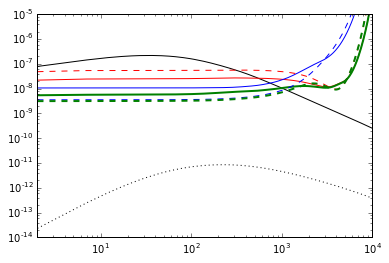

In [42]:
S4.plotNoise()

(10, 10000.0)

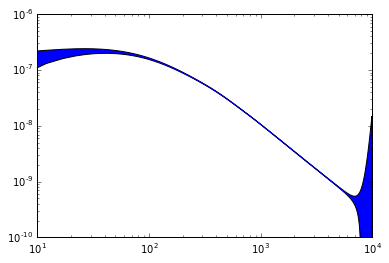

In [43]:
S4.plotBands()
plt.xlim([10,1e4])

In [44]:
for ex in obs:
    Fish, CurlFish = ex.powerFish()        
    amperr = np.sqrt(CurlFish)
    print 'Curl  Fish = %7.4f, S/N=%.4f  %s'%( CurlFish, amperr, ex.label)
    amperr = np.sqrt(Fish)
    print 'kappa Fish = %7.4f, S/N=%.4f  %s'%(Fish, amperr, ex.label)


Curl  Fish =  0.4759, S/N=0.6899  S4_Noise1_Beam3
kappa Fish =  0.0446, S/N=0.2112  S4_Noise1_Beam3
Curl  Fish =  0.0000, S/N=0.0063  planck
kappa Fish =  0.0001, S/N=0.0093  planck
Curl  Fish =  0.0012, S/N=0.0354  SA
kappa Fish =  0.0011, S/N=0.0332  SA
Curl  Fish =  0.0020, S/N=0.0451  SPT3G
kappa Fish =  0.0004, S/N=0.0198  SPT3G
Curl  Fish =  7.5262, S/N=2.7434  Noise0.25_Beam1
kappa Fish =  0.7548, S/N=0.8688  Noise0.25_Beam1


For the bispectrum contributions, we have
$$
\langle \phi(l_1)\phi(l_2)\omega(l_3)\rangle = (2\pi)^2 \delta (l_1+l_2+l_3) b_{l_1,l_2,l_3}^{\phi\phi\omega}
$$
where
$$
 b_{l_1,l_2,l_3}^{\phi\phi\omega} = -8\, l_1\times l_2 \,l_1\cdot l_2 \int_0^{\chi_*} d\chi \frac{W(\chi,\chi_*)^2}{\chi^2} \int_0^{\chi}d\chi' \frac{W(\chi',\chi)W(\chi',\chi_*)}{{\chi'}^2} \left[
 P_\psi\left(\frac{l_1}{\chi},z(\chi)\right) P_\Psi\left(\frac{l_2}{\chi'},z(\chi')\right)  
- (l_1\leftrightarrow l_2)
\right]
$$
Now defining
$$
M_*(l,l') \equiv l^4\int_0^{\chi_*}d\chi \frac{W(\chi,\chi_*)^2}{\chi^2} P_\Psi\left(\frac{l}{\chi}, z(\chi)\right) C_{l'}^\kappa(\chi,\chi_*)
$$
we have
$$
b_{l_1l_2l_3}^{\kappa\kappa\omega} = -\sin 2\phi_{21}\left[ M_*(l_1,l_2)-M_*(l_2,l_1)\right]
$$

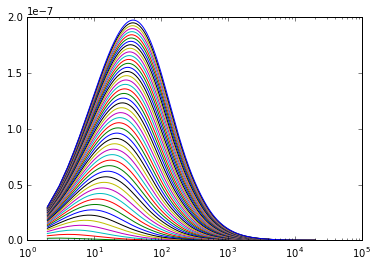

In [45]:
#Get cross-CL kappa for M_* matrix
cls = np.zeros((nchimax,ls.size))
for i, chimax in enumerate(chimaxs[1:]):
    cl = cl_kappa(chimax,chistar)
    cls[i+1,:] = cl
    if i%4==0: plt.semilogx(ls,cl)
cls[0,:]=0   

In [46]:
cl_chi_chistar = RectBivariateSpline(chimaxs,ls,cls)

In [47]:
#Get M_*(l,l') matrix
chis = np.linspace(0,chistar, nz, dtype=np.float64)
zs=results.redshift_at_comoving_radial_distance(chis)
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
win = (1/chis-1/chistar)**2/chis**2
cl=np.zeros(ls.shape)
w = np.ones(chis.shape)
cchi = cl_chi_chistar(chis,ls, grid=True)
Mstar = np.zeros((ls.size,ls.size))
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl = np.dot(dchis*w*PK.P(zs, k, grid=False)*win/k**4,cchi)
    Mstar[i,:] = cl*l**4 #(l*(l+1))**2

In [48]:
#Save metrix for fortran code calculating bispectrum contributions to CL 
if save_files:
    np.savetxt('Mstar_asymm.dat',Mstar - Mstar.T)
    np.savetxt('Mstar_asymm_ls.dat',ls)

In [49]:
Mstarsp = RectBivariateSpline(ls,ls,Mstar)  

Is it detectable? The $2\pi$ factors are a pain, and need $\delta(0) = A/(2\pi)^2 = 1/\pi$, giving
$$
F =\frac{f_{\rm sky}}{2\pi} \int \frac{d^2l_1 d^2 l_2}{(2\pi)^2} \frac{\left(b^{\kappa\kappa\omega}\right)^2}{C^\kappa_{l_1} C^\kappa_{l_2} C^\omega_{l_3}}
$$
for $F^{-1/2}$ to give the fractional error on the amplitude estimate, and $C$ include $N_0$ and (for $\kappa$) signal variance.

In [50]:
def bi_born(l1,l2,l3):
    cos12 = (l3**2-l1**2-l2**2)/2/l1/l2
    cos23 = (l1**2-l2**2-l3**2)/2/l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2/l3/l1
    return  - 2*cos12*((l1/l2+cos12)*Mstarsp(l1,l2,grid=False) + (l2/l1+cos12)*Mstarsp(l2,l1, grid=False) )  \
            - 2*cos23*((l2/l3+cos23)*Mstarsp(l2,l3,grid=False) + (l3/l2+cos23)*Mstarsp(l3,l2, grid=False) )  \
            - 2*cos31*((l3/l1+cos31)*Mstarsp(l3,l1,grid=False) + (l1/l3+cos31)*Mstarsp(l1,l3 ,grid=False) ) 

def bi_abc(l1,l2,l3):
    cos12 = (l3**2-l1**2-l2**2)/2/l1/l2
    cos23 = (l1**2-l2**2-l3**2)/2/l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2/l3/l1
    return  - 2*cos12*((l1/l2)*Mstarsp(l1,l2,grid=False) + (l2/l1)*Mstarsp(l2,l1, grid=False) )  \
            - 2*cos23*((l2/l3)*Mstarsp(l2,l3,grid=False) + (l3/l2)*Mstarsp(l3,l2, grid=False) )  \
            - 2*cos31*((l3/l1)*Mstarsp(l3,l1,grid=False) + (l1/l3)*Mstarsp(l1,l3 ,grid=False) ) 
        
def bi_lenslens(l1,l2,l3):
    cos12 = (l3**2-l1**2-l2**2)/2/l1/l2
    cos23 = (l1**2-l2**2-l3**2)/2/l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2/l3/l1
    return  - 2*cos12*((cos12)*Mstarsp(l1,l2,grid=False) + (cos12)*Mstarsp(l2,l1, grid=False) )  \
            - 2*cos23*((cos23)*Mstarsp(l2,l3,grid=False) + (cos23)*Mstarsp(l3,l2, grid=False) )  \
            - 2*cos31*((cos31)*Mstarsp(l3,l1,grid=False) + (cos31)*Mstarsp(l1,l3 ,grid=False) ) 
        
        
        
def cl_bi_born(lset, bi=bi_born):
    lset = lset.astype(np.float64)
    cl=np.zeros(lset.shape[0])
    for i, (l1,l2,l3) in enumerate(lset):
        cl[i] = bi(l1,l2,l3)
    return cl

def bi_born_omega(l1,l2,l3):
    #only returns orientation where sin(phi_21) is positive
    cos12 = (l3**2-l1**2-l2**2)/2/l1/l2
    sin12 = np.sqrt(1-cos12**2)
    return -2*cos12*sin12*(Mstarsp(l1,l2,grid=False) - Mstarsp(l2,l1, grid=False) ) 

def cl_bi_omega(lset):
    return cl_bi_born(lset, bi_born_omega)
    

def bi_moment(l1,l,m, nphi=16*acc, spect=bi_born):
    
    def born_phi(phi):
        A = l**2+l1**2/4
        B = l1*l*np.cos(phi)
        l2 = np.sqrt(A - B)
        l3 = np.sqrt(A + B)
        return spect(l1,l2,l3)
    
    t = 0
    if m==0:
        for phi in np.linspace(0, np.pi, num=nphi, endpoint=False):
            t+=born_phi(phi)
        return t/nphi 
    else:
        for phi in np.linspace(0, np.pi, num=nphi, endpoint=False):
            t+=born_phi(phi)*np.cos(m*phi)
        return 2*t/nphi 

In [51]:
def l2_for_l1(ex,ll1):
    if ex.lmaxFish - ll1 < 200:
        l2samp = np.unique(np.hstack((np.arange(ll1,ex.lmaxFish+1,20//acc), ex.lmaxFish)))
    else:    
        if ex.lmaxFish - ll1<1000:
            l2samp = ll1 + np.unique(np.hstack(([0,1,2,3],np.arange(5, 100, 10//acc),
                                                np.arange(120, ex.lmaxFish-ll1+1, 70//acc), ex.lmaxFish-ll1)))
        else:
            l2samp = ll1 + np.unique(np.hstack(([0,1,2,3],np.arange(5, 100, 10//acc),np.arange(120, 900, 70//acc),
                                      np.arange(1000, ex.lmaxFish-ll1+1,150//acc), ex.lmaxFish-ll1)))
    return l2samp
 

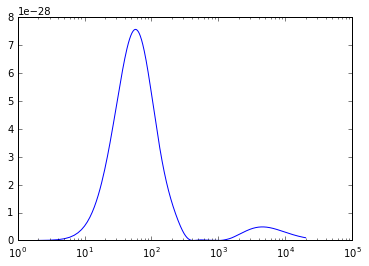

In [52]:
ll=1000
plt.semilogx(lsall,lsall**2*(Mstarsp(lsall,ll,grid=False)-Mstarsp(ll,lsall,grid=False))**2);

In [53]:
def kappa_omega_int2(ex,l1,l2):
      ll1 = int(l1)
      ll2 = int(l2)
      l1 = np.float64(l1)
      l2 = np.float64(l2)
      wig = threej(ll1,ll2,0,0)
      mx = min(ex.lmaxFish,ll2+ll1)
      wig = wig[:mx-(ll2-ll1)+1:2]**2
      l3 = np.arange(ll2-ll1,mx+1, 2, dtype=np.float64)
  
      bi = bi_born_omega(l1,l2,l3)  
      return np.dot(wig*l3,bi**2/ex.noise_curl(l3))/ex.k_noise(l2) *l2

def kappa_omega_fish2(ex):
    tmps = np.zeros(ex.lcalc.shape)
    for i, L1 in enumerate(ex.lcalc):
        L1 = np.float64(L1)   
        LL1 = int(L1)
        for LL2 in range(LL1+1,ex.lmaxFish+1):
          L2 = np.float64(LL2)
          LL2 = int(LL2)
          tmps[i] +=   kappa_omega_int2(ex, L1,L2)
        tmps[i]= ex.fsky*L1*tmps[i]/ex.k_noise(L1)*2/np.pi
    sp = UnivariateSpline(ex.lcalc, tmps, s=0)
    ex.SN['Born-omega'] = np.sqrt(sp.integral(ex.lcalc[0], ex.lcalc[-1]))   
    return tmps


Fish =  9.7756,  S/N= 3.1266  S4_Noise1_Beam3
Fish =  0.0045,  S/N= 0.0672  planck
Fish =  0.1362,  S/N= 0.3691  SA
Fish =  0.1278,  S/N= 0.3575  SPT3G
Fish = 77.2454,  S/N= 8.7889  Noise0.25_Beam1


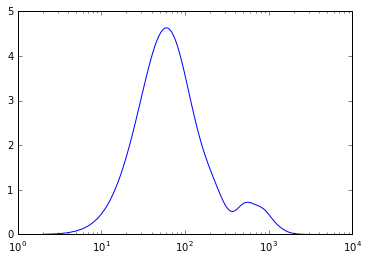

In [54]:
#kappa kappa omega

def kappa_omega_fish(ex):
    tmps = np.zeros(ex.lcalc.shape)
    for i, L1 in enumerate(ex.lcalc):
        L1 = np.float64(L1)   
        LL1 = int(L1)
        L2s = l2_for_l1(ex,LL1)
        if len(L2s)<2: continue
        tmps2 = np.zeros(L2s.shape)
        for j, LL2 in enumerate(L2s):
#        for LL2 in range(LL1+1,ex.lmaxFish+1):
          L2 = np.float64(LL2)
          LL2 = int(LL2)
          if LL2>100:
              nphi = 2*int(L2/10*acc)+1
          else:
              nphi = 2*int(L2)+1

          dphi= 2*np.pi/nphi
          phi = np.linspace(dphi, (nphi-1)/2*dphi,  (nphi-1)//2) 
          sin2phi = np.sin(2*phi)
          l3 = np.sqrt(L2**2+L1**2 + 2*np.cos(phi)*L1*L2)
          sin2phi[l3>ex.lmaxFish]=0
          sin2phi[l3<2]=0    
          tmps2[j] = (Mstarsp(L1,L2,grid=False) - Mstarsp(L2,L1,grid=False))**2/ex.k_noise(L2)*\
                           np.dot(sin2phi,sin2phi/ex.noise_curl(l3))*2*dphi *L2
        sp = UnivariateSpline(L2s, tmps2, s=0)
        tmps[i] = sp.integral(L2s[0], L2s[-1])
        tmps[i] *= ex.fsky*2*L1/ex.k_noise(L1)/(2*np.pi)**2 #2 because only doing ll>l
    sp = UnivariateSpline(ex.lcalc, tmps, s=0)
    ex.SN['Born-omega'] = np.sqrt(sp.integral(ex.lcalc[0], ex.lcalc[-1]))   
    return tmps


for ex in obs:
    kappa_omega_fish(ex)
    print 'Fish = %7.4f,  S/N= %.4f  %s'%( ex.SN['Born-omega']**2,  ex.SN['Born-omega'], ex.label)
    if ex == S4: plt.semilogx(ex.lcalc, ex.lcalc*kappa_omega_fish(ex))
    

For $\kappa\kappa\kappa$ bispectra
$$
F =\frac{f_{\rm sky}}{6\pi} \int \frac{d^2l_1 d^2 l_2}{(2\pi)^2}  
\frac{\left(b^{\kappa\kappa\kappa}\right)^2}{C^\kappa_{l_1} C^\kappa_{l_2} C^\kappa_{l_3}}
$$

In [55]:
#kappa kappa kappa
def integrand_fish(ex,l1,l2):
      ll2 = int(l2)
      l1 = np.float64(l1)
      l2 = np.float64(l2)
      if l2>1200:
        nphi = 2*int(l2/35*acc)+1
      elif l2>300:
        nphi = 2*int(l2/15*acc)+1
      elif l2>100:
        nphi = 2*int(l2/2*acc)+1
      else:
        nphi = 2*int(l2)+1

      dphi= 2*np.pi/nphi
      phi = np.linspace(0, (nphi-1)/2*dphi,  (nphi-1)//2+1)
      w = np.ones(phi.shape) *2
      w[0] = 1
#    if ll1==ll2: w/=2 #but can neglect factors in flat sky approx
      cosphi12 = np.cos(phi)
      l3 = np.sqrt(l1**2+l2**2 + 2*cosphi12*l1*l2)
      w[l3<l2] = 0
      w[l3>ex.lmaxFish] = 0 
      l3 = np.maximum(l3, 2)
      cosphi23 = (l1**2-l3**2-l2**2)/2/l2/l3
      cosphi31 = (l2**2-l3**2-l1**2)/2/l1/l3
      bi = -2*cosphi12*((l1/l2+cosphi12)*Mstarsp(l1,l2,grid=False) + (l2/l1+cosphi12)*Mstarsp(l2,l1,grid=False) )  \
           -2*cosphi23*((l2/l3+cosphi23)*Mstarsp(l2,l3,grid=False) + (l3/l2+cosphi23)*Mstarsp(l3,l2,grid=False) )  \
           -2*cosphi31*((l3/l1+cosphi31)*Mstarsp(l3,l1,grid=False) + (l1/l3+cosphi31)*Mstarsp(l1,l3,grid=False) ) 
      return np.dot(w,bi**2/ex.k_noise(l3))/ex.k_noise(l2) *dphi *l2

def integrand_fish2(ex,l1,l2):
      ll1 = int(l1)
      ll2 = int(l2)
      l1 = np.float64(l1)
      l2 = np.float64(l2)
      wig = threej(ll1,ll2,0,0)
      mx = min(ex.lmaxFish,ll2+ll1)
      if ll1%2==1: 
          wig = wig[ll1+1:mx-(ll2-ll1)+1:2]**2
          l3 = np.arange(ll2+1,mx+1, 2, dtype=np.float64)
      else:
          wig = wig[ll1:mx-(ll2-ll1)+1:2]**2
          l3 = np.arange(ll2,mx+1, 2, dtype=np.float64)
      if not len(l3): return 0
      if False:
           w = np.ones(l3.shape)
      else:
          if ll1==ll2:
            w = np.ones(l3.shape)*0.5
            if int(l3[0])==ll2:
                w[0]= 1./6
          else:
            w = np.ones(l3.shape)
            if int(l3[0])==ll2:
                w[0]=0.5
      
      bi = bi_born(l1,l2,l3)  
      return np.dot(wig*w*l3,bi**2/ex.k_noise(l3))/ex.k_noise(l2) *l2
     
   

Angular Fish = 702.007555303, S/N =26.4954251769 
3j Fish = 710.29206596, S/N =26.6513051455 


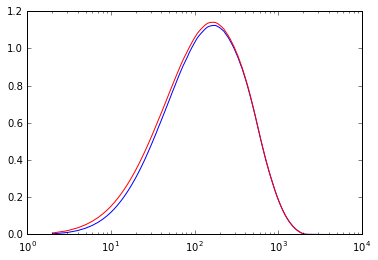

In [56]:
#Fisher if only post-Born signal
#Check don't get anything too different using spherical form
def kappa_born_fish(ex):
    lcalc = ex.lcalc
    tmp1 = np.zeros(lcalc.shape)
    tmp2 = np.zeros(lcalc.shape)
    for i, ll1 in enumerate(lcalc):
        l1 = np.float64(ll1)   
        ll1 = int(ll1)
        l2samp = l2_for_l1(ex,ll1)

        if len(l2samp)<2: break

        tmps1 = np.zeros(l2samp.shape)
        tmps2 = np.zeros(l2samp.shape)
        for j, ll2 in enumerate(l2samp):
            if ll2 > ex.lmaxFish: break
            l2 = np.float64(ll2)
            tmps1[j] = integrand_fish(ex,l1,l2)
            tmps2[j] = integrand_fish2(ex,l1,l2)
        sp = UnivariateSpline(l2samp, tmps2,s=0)
        tmp2[i]=  ex.fsky*sp.integral(l1,l2samp[-1])*l1/ex.k_noise(l1)*2/np.pi
        sp = UnivariateSpline(l2samp, tmps1,s=0)
        tmp1[i]=  ex.fsky*sp.integral(l1,l2samp[-1])*l1/ex.k_noise(l1)/(2*np.pi)**2 *2*np.pi/np.pi #*2/6 
        sp = UnivariateSpline(lcalc, tmp1, s=0)
        ex.SN['Born'] = np.sqrt(sp.integral(lcalc[0], lcalc[-1]))  
        
    return tmp1, tmp2
    
ex=S4
tmp1, tmp2 = kappa_born_fish(ex)
    
plt.semilogx(ex.lcalc, tmp1)
plt.semilogx(ex.lcalc, tmp2, color='r')

print 'Angular Fish = %s, S/N =%s '%(ex.SN['Born']**2, ex.SN['Born'])

sp = UnivariateSpline(ex.lcalc, tmp2, s=0)
Fish = sp.integral(ex.lcalc[0], ex.lcalc[-1])  
print '3j Fish = %s, S/N =%s '%(Fish, np.sqrt(Fish))

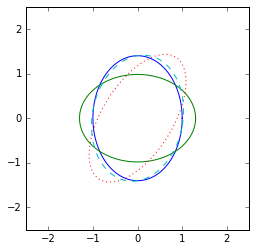

In [57]:
#picture of how composition of two shears gives rotation
phi=np.linspace(0, 2*np.pi,100)
x=np.cos(phi)
y = 1.4*np.sin(phi)
xy =np.array([x,y])
plt.plot(x,y)
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
g1=0.3
g=np.array([[1+g1,0],[0,1-g1]])
xp=g.dot(xy)
plt.plot(xp[0,:],xp[1,:])

g22=0.3
g2=np.array([[1,g22],[g22,1]])
xpp = g2.dot(xy)
plt.plot(xpp[0,:],xpp[1,:], ls=':')

y=xy + np.dot(g,g2).dot(xy) - np.dot(g2,g).dot(xy) 
plt.plot(y[0,:],y[1,:], ls='--')

plt.axes().set_aspect('equal', 'box')

For sources $g$ with window $W_g$ we need
$$
M_g(l,l') \equiv l^2\int_0^{\chi_*}d\chi \frac{W_g(\chi)W(\chi,\chi_*)}{\chi^2} P_{g\Psi}\left(\frac{l}{\chi}, z(\chi)\right) C_{l'}^\kappa(\chi,\chi_*)
$$

In [58]:
#For cross-correlation. Not used for now.
#Get M_g(l,l') matrix

window = np.exp(-(zs-1)**2/0.3**2/2)
win = window*(1/chis-1/chistar)/chis**2
cl=np.zeros(ls.shape)
w = np.ones(chis.shape)
Mg = np.zeros((ls.size,ls.size))
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<1e-4]=0
    w[k>=kmax]=0
    cl = np.dot(dchis*w*PKX.P(zs, k, grid=False)*win/k**4,cchi)
    Mg[i,:] = cl*l**2 #(l*(l+1))**2

In [59]:
def cl_kg(chi_source, chi_source2=None, z_g=1, delta_g=0.3):
    chi_source = np.float64(chi_source)
    if chi_source2 is None: 
        chi_source2 = chi_source
    else:
        chi_source2 = np.float64(chi_source2)
    chis = np.linspace(0,chi_source,nz, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    window = np.exp(-(zs-z_g)**2/delta_g**2/2)
    win = window*(1/chis-1/chi_source2)/chis**2
    cl=np.zeros(ls.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PKX.P(zs, k, grid=False)*win/k**2)
    cl*= ls**2 #(ls*(ls+1))**2
    return cl

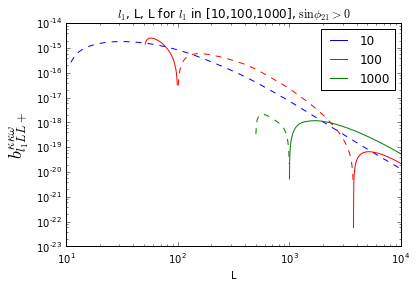

In [60]:
# omega bispectrum
for l1, c in zip([10,100,1000],['b','r','g']):
    litems=[]
    lplot = []
    for i,l in enumerate(ls):
        if l > l1/2:
            lplot.append(l)
            litems.append([l1,l,l])

    litems = np.array(litems)
    testborn = cl_bi_omega(litems)
    plt.loglog(lplot, testborn, color=c)
    plt.loglog(lplot, -testborn, color=c, ls='--', label='_nolegend_')
plt.xlabel('L')
plt.xlim([10,1e4])
plt.ylabel('$b^{\kappa\kappa\omega}_{l_1 L L +}$', fontsize=18)
plt.legend([10,100,1000])
plt.title('$l_1$, L, L for $l_1$ in [10,100,1000], $\sin\phi_{21}>0$');

c:\work\dist\git\camb\pycamb\camb\camb.py:1130: RuntimeWarning: invalid value encountered in log
  return np.exp(self(z, np.log(kh), grid=grid))
C:\Users\Antony Lewis\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars


0.169240958119 3.04459621322


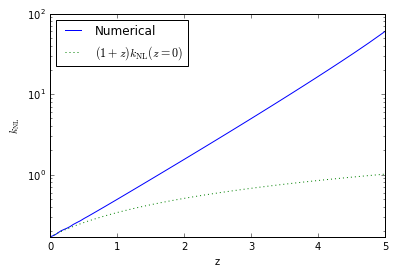

In [61]:
#Things for LSS fitting
#Note assuming k_NL scales with 1+z is a very bad approximation at high redshift
#Just solve for k_NL numerically (BAO don't seem to cause too much problem)
zmax_lss = 5.2
zP = np.exp(np.linspace(0, np.log(zmax_lss+1),50))-1
kNLs = np.zeros(zP.shape)
for i,z in enumerate(zP):
    def f(k):
        return (k**3*PKlin.P(z,k)/(2*np.pi**2)-1)**2
    kNL = optimize.golden(f, brack=[1e-3, 95])
    kNLs[i]=kNL
kNLsp=UnivariateSpline(zP,kNLs, s=0)
plt.semilogy(zP, kNLs)
plt.semilogy(zP, kNLs[0]*(1+zP),ls=':')
plt.xlim([0,5])
plt.ylim([0,100])
plt.xlabel('z')
plt.ylabel(r'$k_{\rmNL}$')
plt.legend(['Numerical',r'$(1+z)k_{\rm NL}(z=0)$'], loc='upper left')
print kNLs[0], kNLsp(2)/(3*kNLs[0])

(0.0001, 100)

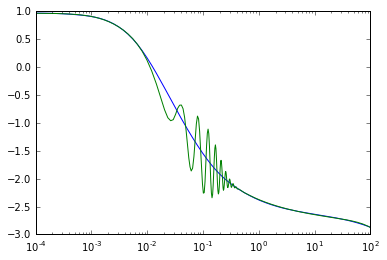

In [62]:
#De-wiggled d ln P/dln k (simple dewiggling recipe)
nk=PKlin(0.1,np.log(PKlin_k),grid=False, dy=1)
w=np.ones(nk.size)
w[PKlin_k<5e-3]=100
w[PKlin_k>1]=10
nksp =  UnivariateSpline(np.log(PKlin_k), nk, s=10, w =w)
plt.semilogx(PKlin_k,nksp(np.log(PKlin_k)))
plt.semilogx(PKlin_k,nk)
plt.xlim([1e-4,kmax])

Note: redshifts have been re-sorted (earliest first)
[ 0.79970776  0.78367322  0.76731001  0.75065378  0.73374291  0.71661801
  0.69932141  0.68189666  0.66438798  0.64683956  0.62929512  0.61179732
  0.5943872   0.57710387  0.559984    0.54306157  0.52636769  0.50993039
  0.49377456  0.47792197  0.46239128  0.44719814  0.43235536  0.41787304
  0.40375878  0.39001788  0.37665353  0.36366705  0.35105805  0.33882471
  0.32696385  0.31547124  0.30434166  0.29356909  0.28314686  0.27306773
  0.26332407  0.25390787  0.24481088  0.23602468  0.22754075  0.21935049
  0.21144529  0.20381662  0.19645596  0.18935492  0.18250523  0.17589874
  0.16952749  0.16338367]


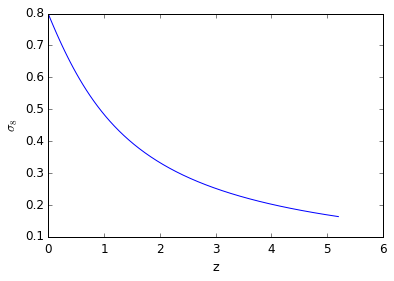

In [88]:
#get sigma_8(z)
pars.set_matter_power(redshifts =zP, kmax=kmax)
results = camb.get_results(pars)
s8vals=results.get_sigma8()[::-1]
print s8vals
s8 = UnivariateSpline(zP, s8vals,s=0)   
plt.plot(zP,s8(zP));
plt.xlabel('z')
plt.ylabel('$\\sigma_8$');


In [89]:
#Fudge fit of http://arxiv.org/abs/astro-ph/0009427
def SC_fit_a(z,k, a1=0.25, a2=3.5, a6=-0.2):
     if z >= zmax_lss: return 1
     q = k/kNLsp(z)
     n= nksp(np.log(k))    
     Q3 = (4-2.**n)/(1+2.**(n+1))
     fac=(q*a1)**(n+a2)
     return (1 + s8(z)**a6*np.sqrt(0.7*Q3)*fac)/(1+fac)

def SC_fit_b(z,k, a3 = 2, a7=1, a8=0):
     if z >= zmax_lss: return 1
     q = k/kNLsp(z)
     n= nksp(np.log(k)) 
     qq = a7*q
     return (1 + 0.2*a3*(n+3)*qq**(n+3+a8))/(1+qq**(n+3.5+a8))


def SC_fit_c(z,k, a4 = 1., a5=2, a9=0):
     if z >= zmax_lss: return 1
     q = k/kNLsp(z)
     n= nksp(np.log(k))    
     return (1+4.5*a4/(1.5+(n+3)**4)*(q*a5)**(n+3+a9))/(1+(q*a5)**(n+3.5+a9))

def GM_fit_a(z,k):
    return SC_fit_a(z,k,a1=0.484,a2=3.740,a6=-0.575)

def GM_fit_b(z,k):
    return SC_fit_b(z,k,a3=-0.849, a7=0.128, a8=-0.722)

def GM_fit_c(z,k):
    return SC_fit_c(z,k,a4=0.392, a5=1.013, a9=-0.926)


SC_fit=[SC_fit_a,SC_fit_b, SC_fit_c]
GM_fit=[GM_fit_a,GM_fit_b, GM_fit_c]

In [90]:
SC_fitsp = []
GM_fitsp = []
for fitsp, fits in zip([SC_fitsp, GM_fitsp], [SC_fit, GM_fit]):
    for fit in fits:
        sc = np.zeros((zs.size,PKlin_k.size))
        for i, z in enumerate(zs):
            sc[i,:] = fit(z,PKlin_k)
        class interp(RectBivariateSpline):
            def get(self,zs,ks):
                return self(zs,ks, grid=False)               
        fitsp.append( interp(zs, PKlin_k,sc))

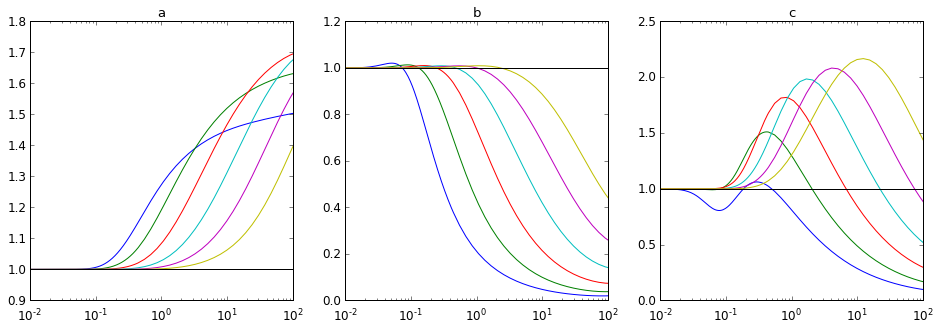

In [91]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
for i, (ax, let) in enumerate(zip(axs,['a','b','c'])):
    for z in np.arange(zmax_lss+1):
        ax.semilogx(PKlin_k,SC_fitsp[i](z, PKlin_k, grid=False))
        ax.set_xlim([1e-2,100])
    ax.set_title(let);

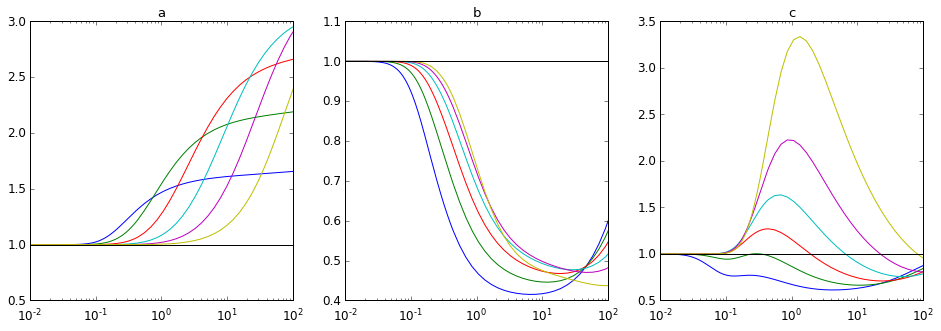

In [92]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
for i, (ax, let) in enumerate(zip(axs,['a','b','c'])):
    for z in np.arange(zmax_lss+1):
        ax.semilogx(PKlin_k,GM_fitsp[i](z, PKlin_k, grid=False))
        ax.set_xlim([1e-2,100])
    ax.set_title(let);

In [93]:
#LSS lensing bispectrum

def B_lss(zs, k1,k2,k3, PK1,PK2,PK3, fitsp=None):
        cos12 = (k3**2-k1**2-k2**2)/2/k1/k2
        cos23 = (k1**2-k2**2-k3**2)/2/k2/k3
        cos31 = (k2**2-k3**2-k1**2)/2/k3/k1
        if fitsp is None:
            F12 = 5./7 + 0.5*(k1/k2 + k2/k1)*cos12 + 2./7*cos12**2
            F23 = 5./7 + 0.5*(k2/k3 + k3/k2)*cos23 + 2./7*cos23**2
            F31 = 5./7 + 0.5*(k3/k1 + k1/k3)*cos31 + 2./7*cos31**2
        else:
            a1 = fitsp[0].get(zs,k1)
            a2 = fitsp[0].get(zs,k2)
            a3 = fitsp[0].get(zs,k3)
            b1 = fitsp[1].get(zs,k1)
            b2 = fitsp[1].get(zs,k2)
            b3 = fitsp[1].get(zs,k3)
            c1 = fitsp[2].get(zs,k1)
            c2 = fitsp[2].get(zs,k2)
            c3 = fitsp[2].get(zs,k3)

            F12 = 5./7*a1*a2 + b1*b2*0.5*(k1/k2 + k2/k1)*cos12 + c1*c2*2./7*cos12**2
            F23 = 5./7*a2*a3 + b2*b3*0.5*(k2/k3 + k3/k2)*cos23 + c2*c3*2./7*cos23**2
            F31 = 5./7*a1*a3 + b3*b1*0.5*(k3/k1 + k1/k3)*cos31 + c3*c1*2./7*cos31**2
        return 2*F12*PK1*PK2 + 2*F23*PK2*PK3 + 2*F31*PK3*PK1
    

def cl_bi(chi_source, ls, fitsp = None):
    ls = ls.astype(np.float64)
    chi_source = np.float64(chi_source)
    chis = np.linspace(0,chi_source,nz_bi, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    Phirat = np.sqrt(PK.P(zs, 0.05, grid=False)/Pdelta.P(zs, 0.05, grid=False))
    win = (1/chis-1/chi_source)**3/chis**4
    cl=np.zeros(ls.shape[0])
    w = np.ones(chis.shape[0])
    for i, (l1,l2,l3) in enumerate(ls):
        k1=(l1)/chis
        k2=(l2)/chis
        k3=(l3)/chis
        w[:]=1
        w[k1<1e-4]=0
        w[k1>=kmax]=0
        w[k2<1e-4]=0
        w[k2>=kmax]=0
        w[k3<1e-4]=0
        w[k3>=kmax]=0    
        PK1=Pdelta.P(zs, k1, grid=False)
        PK2=Pdelta.P(zs, k2, grid=False)
        PK3=Pdelta.P(zs, k3, grid=False)
        B = B_lss(zs,k1,k2,k3, PK1,PK2,PK3, fitsp)
        cl[i] = np.dot(dchis, w*win*Phirat**3*B/k1**2/k2**2/k3**2)*(l1*l2*l3)**2
#        cl[i] = np.dot(dchis, w*win*(chis**2*Phirat)**3*B)
 
    return cl


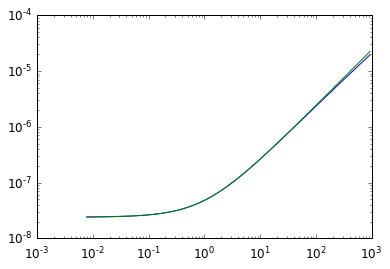

In [94]:
#check analytic approx for phi-delta relation against CAMB power ratio
Phirat = np.sqrt(PK.P(zs, 0.05, grid=False)/Pdelta.P(zs, 0.05, grid=False))
plt.loglog(zs,Phirat)
plt.loglog(zs, 3/2.*(pars.omegac+pars.omegab)*(pars.H0)**2*(3.3356e-6)**2*(1+zs)  );

In [95]:
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,l,l

test=cl_bi(chistar,litems)
test_SC=cl_bi(chistar,litems,SC_fitsp)
test_GM=cl_bi(chistar,litems,GM_fitsp)

testborn = cl_bi_born(litems)
testborn2 = 3* Mstarsp(lsamp,lsamp,grid=False) #analytic simplification

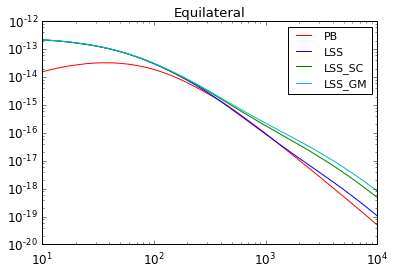

In [96]:
plt.loglog(lsamp,testborn, color='r')
plt.loglog(lsamp,test, color='b')
plt.loglog(lsamp,test_SC, color='g')
plt.loglog(lsamp,test_GM, color='c')

#plt.loglog(lsamp,testborn2,ls='-',color='m')
#plt.loglog(lsamp,test2, color='g')

plt.xlim([10,1e4])
plt.legend(['PB','LSS', 'LSS_SC', 'LSS_GM'])
plt.title('Equilateral');
if save_files:
    np.savetxt('equilateral_z%s.txt'%ztag,  np.vstack((lsamp,testborn, test, test_SC, test_GM)).T)


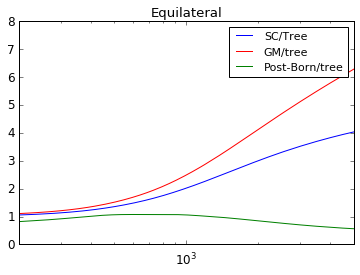

In [97]:
plt.semilogx(lsamp,test_SC/test, color='b')
plt.semilogx(lsamp,test_GM/test, color='r')
plt.semilogx(lsamp,testborn/test, color='g')

plt.xlim([200, 5000])
plt.legend(['SC/Tree','GM/tree', 'Post-Born/tree'])
plt.title('Equilateral');

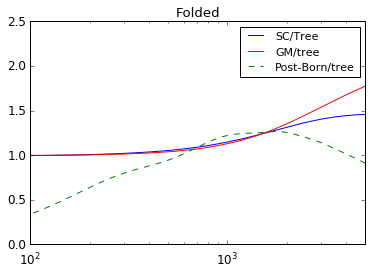

In [98]:
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,l/2.,l/2.

test=cl_bi(chistar,litems)
test_SC=cl_bi(chistar,litems,SC_fitsp)
test_GM=cl_bi(chistar,litems,GM_fitsp)
testborn = cl_bi_born(litems)
plt.semilogx(lsamp,test_SC/test, color='b')
plt.semilogx(lsamp,test_GM/test, color='r')
plt.semilogx(lsamp,-testborn/test, color='g', ls='--')

plt.xlim([100, 5000])
plt.legend(['SC/Tree','GM/tree', 'Post-Born/tree']);
plt.title('Folded');
if save_files:
    np.savetxt('folded_z%s.txt'%ztag,  np.vstack((lsamp,testborn, test, test_SC, test_GM)).T)

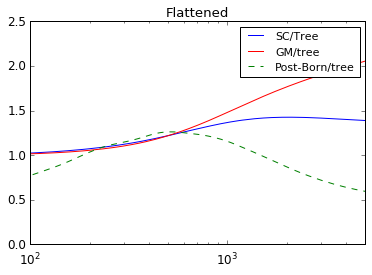

In [99]:
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,2*l,3*l

test=cl_bi(chistar,litems)
test_SC=cl_bi(chistar,litems,SC_fitsp)
test_GM=cl_bi(chistar,litems,GM_fitsp)
testborn = cl_bi_born(litems)
plt.semilogx(lsamp,test_SC/test, color='b')
plt.semilogx(lsamp,test_GM/test, color='r')
plt.semilogx(lsamp,-testborn/test, color='g', ls='--')

plt.xlim([100, 5000])
plt.legend(['SC/Tree','GM/tree', 'Post-Born/tree']);
plt.title('Flattened');
if save_files:
    np.savetxt('flattened123_z%s.txt'%ztag,  np.vstack((lsamp,testborn, test, test_SC, test_GM)).T)

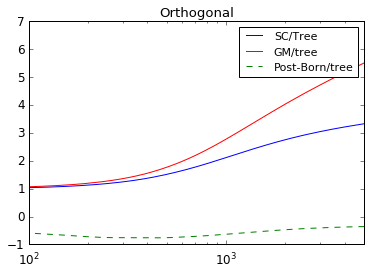

In [100]:
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,2*l,2*l

test=cl_bi(chistar,litems)
test_SC=cl_bi(chistar,litems,SC_fitsp)
test_GM=cl_bi(chistar,litems,GM_fitsp)
testborn = cl_bi_born(litems)
plt.semilogx(lsamp,test_SC/test, color='b')
plt.semilogx(lsamp,test_GM/test, color='r')
plt.semilogx(lsamp,-testborn/test, color='g', ls='--')

plt.xlim([100, 5000])
plt.legend(['SC/Tree','GM/tree', 'Post-Born/tree']);
plt.title('Orthogonal');
if save_files:
    np.savetxt('other122_z%s.txt'%ztag,  np.vstack((lsamp,testborn, test, test_SC, test_GM)).T)

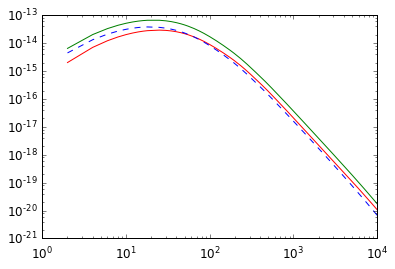

In [101]:
#contributions from lens-lens, and born-like grad^3phi terms:
test_lenslens = cl_bi_born(litems, bi_lenslens)
test_abc = cl_bi_born(litems, bi_abc)
plt.loglog(lsamp,testborn, color='r')
plt.loglog(lsamp,-test_lenslens, color='b', ls='--')
plt.loglog(lsamp,test_abc, color='g');
#so equilateral is negative from lenslens, but dominated by twice larger positive PB term

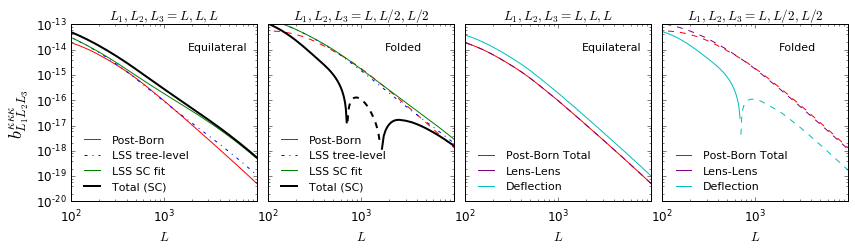

In [102]:
setPlotStyle()

litems =np.zeros((lsamp.size,3))
fig, axes = plt.subplots(1,4,figsize=(12,3.6), sharey=True, sharex=True)
l1=100
treestyle='-.'
for p,  ax in zip([0,1], axes[0:2]):
    for i,l in enumerate(lsamp):
        if p==0:
            litems[i,:]=l,l,l
        else:
            litems[i,:]=l,l/2.,l/2.            

    test=cl_bi(chistar,litems)
    test_SC=cl_bi(chistar,litems, fitsp=SC_fitsp)
    testborn = cl_bi_born(litems)

    ax.loglog(lsamp, testborn, color='r',ls='-')
    ax.loglog(lsamp, -testborn, color='r',ls='--',label='_nolegend_')
    ax.loglog(lsamp, test, color='b', ls=treestyle)
    ax.loglog(lsamp, test_SC, color='g')

    ax.loglog(lsamp, test_SC+testborn, color='k', ls='-', lw=2)
    ax.loglog(lsamp, -(test_SC+testborn), color='k', ls='--', lw=2,label='_nolegend_')
    ax.legend(['Post-Born','LSS tree-level','LSS SC fit', 'Total (SC)'], frameon =False, loc='lower left')
    if p==1:
        ax.set_title('$L_1, L_2, L_3 = L, L/2, L/2$')
        ax.text(1800,1e-14,'Folded')
    else:
        ax.set_title('$L_1,L_2, L_3 = L, L, L$')
        ax.text(1800,1e-14,'Equilateral')

    ax.set_xlabel('$L$')
    ax.set_xlim([l1,1e4])
    ax.set_ylim([1e-20,1e-13])

for p,  ax in zip([0,1], axes[2:]):
    for i,l in enumerate(lsamp):
        if p==0:
            litems[i,:]=l,l,l
        else:
            litems[i,:]=l,l/2.,l/2.            

    testborn = cl_bi_born(litems)

    ax.loglog(lsamp, testborn, color='r',ls='-')
    ax.loglog(lsamp, -testborn, color='r',ls='--',label='_nolegend_')
    
    test_lenslens = cl_bi_born(litems, bi_lenslens)
    test_abc = cl_bi_born(litems, bi_abc)
    
    ax.loglog(lsamp, test_lenslens, color='purple',)
    ax.loglog(lsamp, -test_lenslens, color='purple', ls='--',label='_nolegend_')

    ax.loglog(lsamp, test_abc, color='c')
    ax.loglog(lsamp, -test_abc, color='c',ls='--',label='_nolegend_')

    ax.legend(['Post-Born Total','Lens-Lens','Deflection'], frameon =False, loc='lower left')
    if p==1:
        ax.set_title('$L_1, L_2, L_3 = L, L/2, L/2$')
        ax.text(1800,1e-14,'Folded')
    else:
        ax.set_title('$L_1,L_2, L_3 = L, L, L$')
        ax.text(1800,1e-14,'Equilateral')
    ax.set_xlabel('$L$')
    ax.set_xlim([l1,1e4])
    ax.set_ylim([1e-20,1e-13])
    
    
ax.set_xticks([100,1000])
axes[0].set_ylabel('$b^{\kappa\kappa\kappa}_{L_1 L_2 L_3}$', fontsize=18);
fig.subplots_adjust(hspace=0)
fig.tight_layout(h_pad=0, w_pad=0)
#fig.savefig('Equilateral_Folded_100.pdf', bbox_inches='tight')

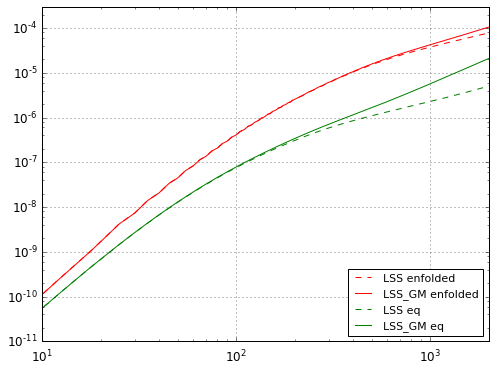

In [103]:
#Comparison with Namikawa (http://arxiv.org/abs/1604.08578)
plt.figure(figsize=(8,6))
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,l,l

testeq=cl_bi(chistar,litems)
testeq_SC=cl_bi(chistar,litems,SC_fitsp)
testeq_GM=cl_bi(chistar,litems,GM_fitsp)

for i,l in enumerate(lsamp):
    litems[i,:]=l,l/2,l/2

test=cl_bi(chistar,litems)
test_SC=cl_bi(chistar,litems,SC_fitsp)
test_GM=cl_bi(chistar,litems,GM_fitsp)

testborn = cl_bi_born(litems)
fac = lsamp**4./(2*np.pi)**2
#plt.loglog(lsamp,-fac*testborn, color='r', ls=':')
plt.loglog(lsamp,fac*test, color='r', ls='--')
#plt.loglog(lsamp,fac*test_SC, color='g')
plt.loglog(lsamp,fac*test_GM, color='r')

plt.loglog(lsamp,fac*testeq, color='g', ls='--')
plt.loglog(lsamp,fac*testeq_GM, color='g')

#plt.loglog(lsamp,testborn2,ls='-',color='m')
#plt.loglog(lsamp,test2, color='g')

plt.xlim([10,2000])
plt.ylim([1e-11,3e-4])
plt.legend(['LSS enfolded',  'LSS_GM enfolded','LSS eq',  'LSS_GM eq'], loc='lower right')
plt.grid(True)

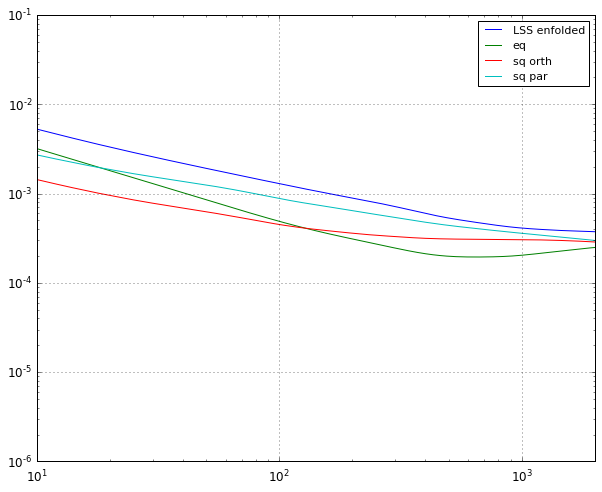

In [104]:
fac = lsamp**4./(2*np.pi)**2

def plot_scaled(test, items):
    t = test.copy()
    for i, (l1,l2,l3) in enumerate(items):
        t[i]/=np.sqrt(S4.cosmic_var(l1)*S4.cosmic_var(l2)*S4.cosmic_var(l3))
    plt.loglog(lsamp, t)
    
plt.figure(figsize=(10,8))
litems =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems[i,:]=l,l,l

testeq=cl_bi(chistar,litems)
testeq_SC=cl_bi(chistar,litems,SC_fitsp)
testeq_GM=cl_bi(chistar,litems,GM_fitsp)

litems2 =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems2[i,:]=2*l,l,l

test=cl_bi(chistar,litems2)
test_SC=cl_bi(chistar,litems2,SC_fitsp)
test_GM=cl_bi(chistar,litems2,GM_fitsp)


litems3 =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems3[i,:]=l,4*l,4*l

testsq=cl_bi(chistar,litems3)
testsq_SC=cl_bi(chistar,litems3,SC_fitsp)
testsq_GM=cl_bi(chistar,litems3,GM_fitsp)

litems4 =np.zeros((lsamp.size,3))
for i,l in enumerate(lsamp):
    litems4[i,:]=l,4*l,5*l

testsqor=cl_bi(chistar,litems4)
testsqor_SC=cl_bi(chistar,litems4,SC_fitsp)
testsqor_GM=cl_bi(chistar,litems4,GM_fitsp)

#testborn = cl_bi_born(litems)
plot_scaled(test_GM, litems2)
plot_scaled(testeq_GM,litems)
plot_scaled(testsq_GM,litems3)
plot_scaled(testsqor_GM,litems3)

plt.xlim([10,2000])
#plt.ylim([1e-11,3e-4])
plt.legend(['LSS enfolded',  'eq','sq orth' ,'sq par'])
plt.grid(True)

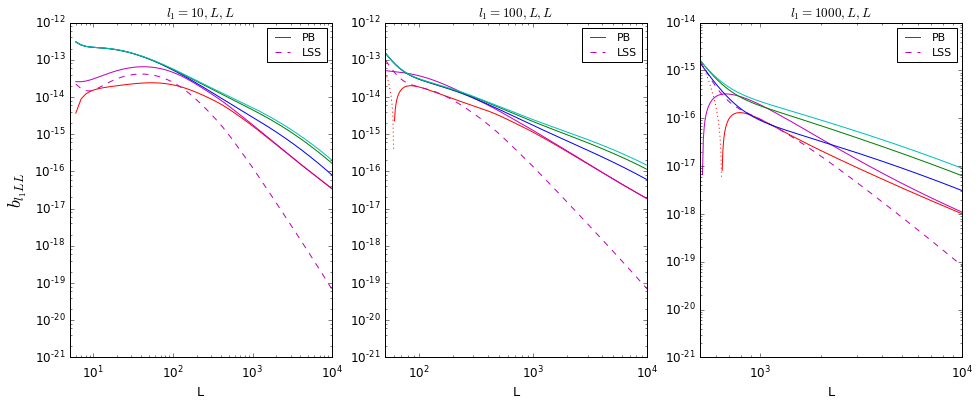

In [105]:
#Magenta lines show decomposition into lens-lens and ray deflection
fig, axes = plt.subplots(1,3,figsize=(16,6))
for l1,  ax in zip([10,100,1000], axes):
    litems=[]
    lplot = []
    for i,l in enumerate(ls):
        if l > l1/2:
            lplot.append(l)
            litems.append([l1,l,l])

    litems = np.array(litems)
    test=cl_bi(chistar,litems)
    test_SC=cl_bi(chistar,litems, fitsp=SC_fitsp)
    test_GM=cl_bi(chistar,litems, fitsp=GM_fitsp)

    testborn = cl_bi_born(litems)
    test_lenslens = cl_bi_born(litems, bi_lenslens)
    test_abc = cl_bi_born(litems, bi_abc)

    ax.loglog(lplot, testborn, color='r')
    ax.loglog(lplot, -test_lenslens, color='m',ls='--')
    ax.loglog(lplot, test_abc, color='m')

    ax.loglog(lplot, test, color='b')
    ax.loglog(lplot, test_SC, color='g')
    ax.loglog(lplot, test_GM, color='c')
  
    ax.legend(['PB','LSS'])
    ax.loglog(lplot,-testborn, color='r',ls=':')
    ax.loglog(lplot, -test, color='b', ls=':')
    ax.set_title('$l_1 = %s, L, L$'%l1)
    ax.set_xlabel('L')
    ax.set_xlim([l1/2,lmax/2])
axes[0].set_ylabel('$b_{l_1 L L}$', fontsize=18);

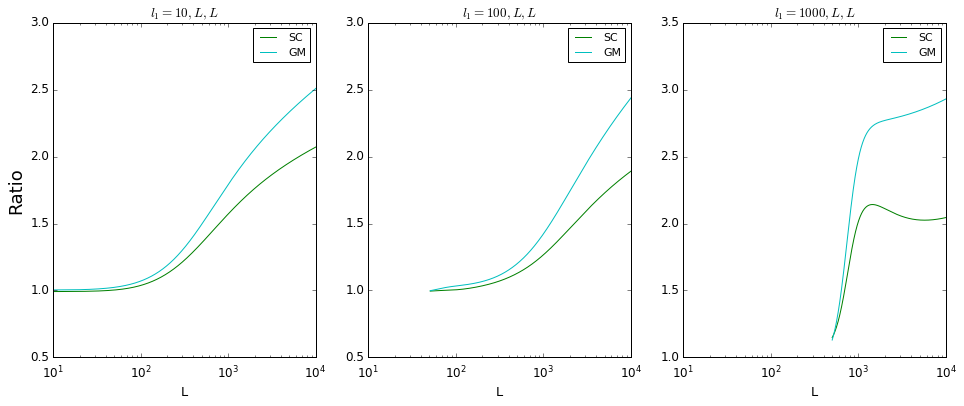

In [106]:
fig, axes = plt.subplots(1,3,figsize=(16,6))
for l1,  ax in zip([10,100,1000], axes):
    litems=[]
    lplot = []
    for i,l in enumerate(ls):
        if l > l1/2:
            lplot.append(l)
            litems.append([l1,l,l])

    litems = np.array(litems)
    test=cl_bi(chistar,litems)
   
    test_SC=cl_bi(chistar,litems, fitsp=SC_fitsp)
    test_GM=cl_bi(chistar,litems, fitsp=GM_fitsp)

    ax.semilogx(lplot, test_SC/test, color='g')
    ax.semilogx(lplot, test_GM/test, color='c')
  
    ax.legend(['SC','GM'])
    ax.set_title('$l_1 = %s, L, L$'%l1)
    ax.set_xlabel('L')
    ax.set_xlim([10,1e4])
axes[0].set_ylabel('Ratio', fontsize=18);

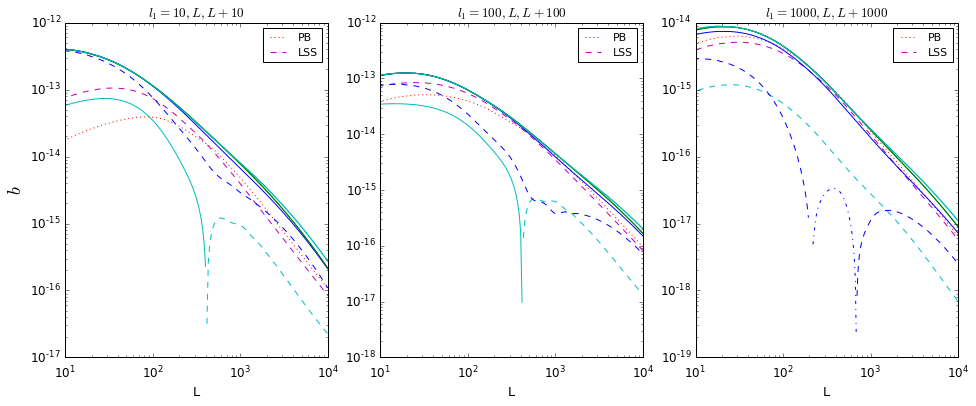

In [107]:
litems =np.zeros((lsamp.size,3))
fig, axes = plt.subplots(1,3,figsize=(16,6))
for l1,  ax in zip([10,100,1000], axes):
    for i,l in enumerate(lsamp):
        litems[i,:]=l1,l,l+l1

    test=cl_bi(chistar,litems)
    test_SC=cl_bi(chistar,litems, fitsp=SC_fitsp)
    test_GM=cl_bi(chistar,litems, fitsp=GM_fitsp)
    
    testborn = cl_bi_born(litems)
    test_lenslens = cl_bi_born(litems, bi_lenslens)
    test_abc = cl_bi_born(litems, bi_abc)

    ax.loglog(lsamp, -testborn, color='r',ls=':')
    ax.loglog(lsamp, -test_lenslens, color='m',ls='--')
    ax.loglog(lsamp, test_abc, color='c')
    ax.loglog(lsamp, -test_abc, color='c',ls='--')

    ax.loglog(lsamp, -test, color='b',ls=':')
    ax.loglog(lsamp, test_SC, color='g')
    ax.loglog(lsamp, test_GM, color='c')

    ax.legend(['PB','LSS'])
    ax.loglog(lsamp,testborn, color='r',ls='-')
    ax.loglog(lsamp, test, color='b', ls='-')
    ax.loglog(lsamp, test_SC, color='g', ls='-')
    ax.loglog(lsamp, test_GM, color='c', ls='-')

    ax.loglog(lsamp, test_SC+testborn, color='b', ls='--')
    ax.loglog(lsamp, -(test_SC+testborn), color='b', ls='-.')

    ax.set_title('$l_1 = %s, L, L+%s$'%(l1,l1))
    ax.set_xlabel('L')
    ax.set_xlim([10,1e4])
axes[0].set_ylabel('$b$', fontsize=18);

In [108]:
chi_source=chistar

chi_source = np.float64(chi_source)
chis = np.linspace(0,chi_source,nz_bi, dtype=np.float64)
zs=results.redshift_at_comoving_radial_distance(chis)
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
Phirat = np.sqrt(PK.P(zs, 0.05, grid=False)/Pdelta.P(zs, 0.05, grid=False))
win = (1/chis-1/chi_source)**3/chis**4

def integrand_fish_lss(ex,l1,l2, LSS = True, born=False, fitsp=None, corr=False):
    l1 =np.float64(l1)
    l2 =np.float64(l2)
    
    ll2 = int(l2)
    if l2>1200:
      nphi = 2*int(l2/35*acc)+1
    elif l2>300:
      nphi = 2*int(l2/10*acc)+1
    elif l2>100:
      nphi = 2*int(l2/2*acc)+1
    else:
      nphi = 2*int(l2)+1

    dphi= 2*np.pi/nphi
    phi = np.linspace(0, (nphi-1)/2*dphi,  (nphi-1)//2+1)
    wphi = np.ones(phi.shape) *2
    wphi[0] = 1
 
    cosphi12 = np.cos(phi)
    l3s = np.sqrt(l1**2+l2**2 + 2*cosphi12*l1*l2)
    if LSS:
        w = np.ones(chis.shape[0])
        k1=(l1+0.5)/chis
        k2=(l2+0.5)/chis
        w[k1<1e-4]=0
        w[k1>=kmax]=0
        w[k2<1e-4]=0
        w[k2>=kmax]=0
        PK1=Pdelta.P(zs, k1, grid=False)
        PK2=Pdelta.P(zs, k2, grid=False)
    bi = np.zeros(l3s.shape)
    bi2 = np.zeros(l3s.shape)
    for i, l3 in enumerate(l3s):
        if l3<l1 or l3<l2 or l3>ex.lmaxFish: continue
        if LSS:
            k3=(l3+0.5)/chis
            ww=w.copy()
            ww[k3<1e-4]=0
            ww[k3>=kmax]=0
            PK3=Pdelta.P(zs, k3, grid=False)
            B = B_lss(zs, k1,k2,k3, PK1,PK2,PK3, fitsp=fitsp)
            bi[i] = np.dot(dchis, ww*win*Phirat**3*B/k1**2/k2**2/k3**2)*(l1*l2*l3)**2
        if corr:
            bi2[i] = bi_born(l1,l2,l3)
        if born: 
            bi[i] += bi_born(l1,l2,l3)
    if not corr: bi2 = bi
    return np.dot(wphi*bi,bi2/ex.k_noise(l3s))/ex.k_noise(l2) *dphi *l2  


       Born Fish =  701.998, S/N =  26.495  S4_Noise1_Beam3 
     LSS_SC Fish = 1573.897, S/N =  39.672  S4_Noise1_Beam3 
LSS_SC_Born Fish =  646.894, S/N =  25.434  S4_Noise1_Beam3 
        LSS Fish =  925.945, S/N =  30.429  S4_Noise1_Beam3 
       Born Fish =    0.397, S/N =   0.630  planck 
     LSS_SC Fish =    1.185, S/N =   1.089  planck 
LSS_SC_Born Fish =    0.618, S/N =   0.786  planck 
        LSS Fish =    1.070, S/N =   1.035  planck 
       Born Fish =   12.038, S/N =   3.470  SA 
     LSS_SC Fish =   26.759, S/N =   5.173  SA 
LSS_SC_Born Fish =   11.500, S/N =   3.391  SA 
        LSS Fish =   21.653, S/N =   4.653  SA 
       Born Fish =    6.710, S/N =   2.590  SPT3G 
     LSS_SC Fish =   13.335, S/N =   3.652  SPT3G 
LSS_SC_Born Fish =    5.395, S/N =   2.323  SPT3G 
        LSS Fish =   10.257, S/N =   3.203  SPT3G 
       Born Fish = 6929.096, S/N =  83.241  Noise0.25_Beam1 
     LSS_SC Fish = 20048.091, S/N = 141.591  Noise0.25_Beam1 
LSS_SC_Born Fish = 9833.569, 

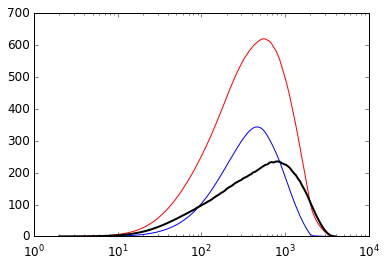

In [109]:
#run with acc=2 to get nicer result
vars = ['Born','LSS_SC','LSS_SC_Born','LSS']

def FisherContribs(ex,LSS=True, born =False, fitsp=None, corr=False):
    lcalc = ex.lcalc
    tmps = np.zeros(lcalc.shape)
    for i, ll1 in enumerate(lcalc):
        l1 = np.float64(ll1)
        ll1 = int(ll1)
        l2samp = l2_for_l1(ex,l1)
        if len(l2samp)<2: break
        tmps2 = np.zeros(l2samp.shape)
        for j, ll2 in enumerate(l2samp):
            l2 = np.float64(ll2)
            tmps2[j] = integrand_fish_lss(ex,l1,l2, LSS=LSS, born=born, fitsp=fitsp, corr=corr)
        sp = UnivariateSpline(l2samp, tmps2,s=0)
        tmps[i]=  sp.integral(l1,l2samp[-1])*l1/ex.k_noise(l1)/(2*np.pi)**2 *2*np.pi*ex.fsky/np.pi #*2/6
    return tmps

def getKappaFisher(ex):
    ex.Fisher['LSS_SC'] =  FisherContribs(ex,LSS=True,born=False, fitsp=SC_fitsp)
    ex.Fisher['LSS'] =   FisherContribs(ex,LSS=True,born=False, fitsp=None)
    ex.Fisher['LSS_SC_Born'] =   FisherContribs(ex,LSS=True, born=True, fitsp=SC_fitsp)
    ex.Fisher['Born'] = FisherContribs(ex,LSS=False, born=True, fitsp=None)
    for var in vars:
        sp = UnivariateSpline(ex.lcalc[:-1], ex.Fisher[var][:-1], s=0)
        ex.SN[var] = np.sqrt(sp.integral(ex.lcalc[0], ex.lcalc[-1]))

for ex in obs:
    getKappaFisher(ex)
    for var in vars:
         print '%11s Fish = %8.3f, S/N =%8.3f  %s '%(var, ex.SN[var]**2, ex.SN[var], ex.label) 
    
ex = S4
plt.semilogx(ex.lcalc, ex.lcalc*ex.Fisher['LSS_SC'], color='r')
plt.semilogx(ex.lcalc, ex.lcalc*ex.Fisher['Born'], color='b')
plt.semilogx(ex.lcalc, ex.lcalc*ex.Fisher['LSS_SC_Born'], color='k', lw=2);


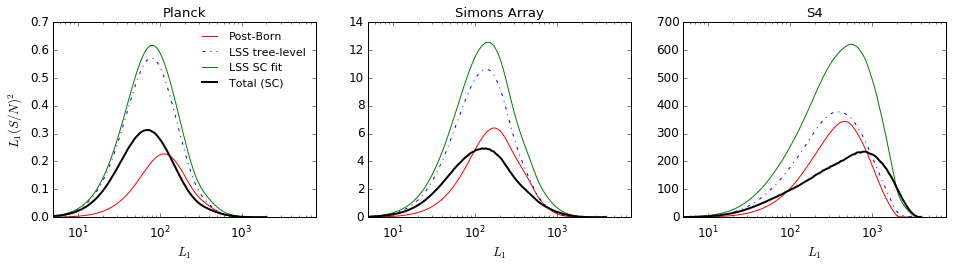

In [110]:
setPlotStyle()
fig, axes = plt.subplots(1,3,figsize=(16,3.5))
for i, (ax,tag,tit) in enumerate(zip(axes,['planck','SA','S4_Noise1_Beam3'],['Planck','Simons Array','S4'])):
    ex = expts[tag]
    if ex is None: continue
    lcalc =ex.lcalc
    ax.semilogx(lcalc, lcalc*ex.Fisher['Born'], color='r')
    ax.semilogx(lcalc, lcalc*ex.Fisher['LSS'], color='b',ls='-.')
    ax.semilogx(lcalc, lcalc*ex.Fisher['LSS_SC'], color='g')
    ax.semilogx(lcalc, lcalc*ex.Fisher['LSS_SC_Born'], color='k', lw=2)
    ax.set_xlim([5, 8000])
    if i==0: ax.legend(['Post-Born','LSS tree-level','LSS SC fit','Total (SC)'], loc='upper right',frameon=False)
    if not i: ax.set_ylabel(r'$L_1 (S/N)^2$')
    ax.set_xlabel('$L_1$');
    ax.set_title(tit)
#fig.savefig('kappa_bi_SN.pdf', bbox_inches='tight')

(2, 2000)

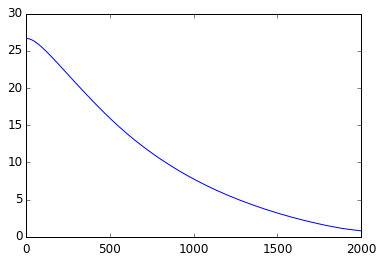

In [111]:
#Cululative S/N
cum = np.zeros(lcalc.shape)
for i,l in enumerate(lcalc):
    cum[i]=sp.integral(l, lcalc[-1])
plt.plot(lcalc,np.sqrt(cum))
plt.xlim([lcalc[0],2000])

In [112]:
if False:
    lstart = 20
    lplot = np.hstack((lstart,lstart+np.exp(np.linspace(np.log(5), np.log(1010),60)).astype(np.int), lsall[1050:lmaxFish-50:50],lmaxFish))
    #lplot = np.arange(lstart,lmaxFish,5)
    tmps=np.zeros(lplot.shape)
    for i,l2 in enumerate(lplot):
        tmps[i]+=integrand_fish_lss(lstart,l2)
    plt.semilogx(lplot, tmps);

In [113]:
def bi_lss(l1,l2,l3, fitsp=None):
    k1=(l1+0.5)/chis
    k2=(l2+0.5)/chis
    w = np.ones(chis.shape[0])
    w[:]=1
    w[k1<1e-4]=0
    w[k1>=kmax]=0
    w[k2<1e-4]=0
    w[k2>=kmax]=0
    k1=(l1)/chis
    k2=(l2)/chis
    PK1=Pdelta.P(zs, k1, grid=False)
    PK2=Pdelta.P(zs, k2, grid=False)
    k3=(l3)/chis
    ww=w.copy()
    ww[k3<1e-4]=0
    ww[k3>=kmax]=0
    #ww[np.maximum(k1,np.maximum(k2,k3))/np.minimum(k1,np.minimum(k2,k3))<4] = 0
    PK3=Pdelta.P(zs, k3, grid=False)
    
    B = B_lss(zs, k1,k2,k3, PK1,PK2,PK3, fitsp=fitsp)
    return np.dot(dchis, ww*win*Phirat**3*B/k1**2/k2**2/k3**2)*(l1*l2*l3)**2
        
def bi_lss_SC(l1,l2,l3):
    return bi_lss(l1,l2,l3,fitsp=SC_fitsp)


In [114]:
#Look at angular moments for semi-squeezed (and actually general) shapes
l1=100
lmin=l1//2+1
lplot = np.hstack((np.arange(lmin,l1+200, 10), np.exp(np.linspace(np.log(l1+220), np.log(lmax/2),40)).astype(np.int))).astype(np.float64)
#lplot=np.arange(l1,2000)
mom0=np.zeros(lplot.size)
mom2=np.zeros(lplot.size)
mom4=np.zeros(lplot.size)
mom6=np.zeros(lplot.size)
for i,l in enumerate(lplot):
    mom0[i]=bi_moment(l1,l,0)
    mom2[i]=bi_moment(l1,l,2)
    mom4[i]=bi_moment(l1,l,4)
    mom6[i]=bi_moment(l1,l,6)
    

In [115]:
lssmom0=np.zeros(lplot.size)
lssmom2=np.zeros(lplot.size)
lssmom4=np.zeros(lplot.size)
lssmom6=np.zeros(lplot.size)
for i,l in enumerate(lplot):
    lssmom0[i]=bi_moment(l1,l,0, spect=bi_lss)
    lssmom2[i]=bi_moment(l1,l,2, spect=bi_lss)
    lssmom4[i]=bi_moment(l1,l,4, spect=bi_lss)
    lssmom6[i]=bi_moment(l1,l,6, spect=bi_lss)


In [116]:
lssSCmom0=np.zeros(lplot.size)
lssSCmom2=np.zeros(lplot.size)
for i,l in enumerate(lplot):
    lssSCmom0[i]=bi_moment(l1,l,0, spect=bi_lss_SC)
    lssSCmom2[i]=bi_moment(l1,l,2, spect=bi_lss_SC)


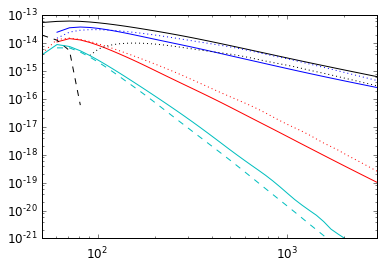

In [117]:
p=plt.loglog
p(lplot,lssmom0, color='k', ls='-')
p(lplot,lssmom2, color='b', ls='-')
p(lplot,lssmom4, color='r', ls='-')

p(lplot,mom0, color='k',ls='--')
p(lplot,mom2, color='b',ls='--')
p(lplot,mom4, color='r',ls='--')
p(lplot,-mom0, color='k', ls=':')
p(lplot,-mom2, color='b', ls=':')
p(lplot,-mom4, color='r', ls=':')

p(lplot,-mom6, color='c')
p(lplot,lssmom6, color='c', ls='--')

plt.ylim([1e-21,1e-13])
plt.xlim([lmin, 3000]);


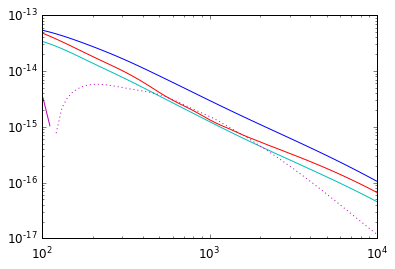

In [118]:
p=plt.loglog
p(lplot,lssmom0, color='b', ls='-')
p(lplot,lssmom2, color='c', ls='-')
p(lplot,lssmom0+mom0, color='r', ls='-')
p(lplot,lssmom2+mom2, color='m', ls='-')
p(lplot,-(lssmom2+mom2), color='m', ls=':')
plt.xlim([l1,lmax/2]);


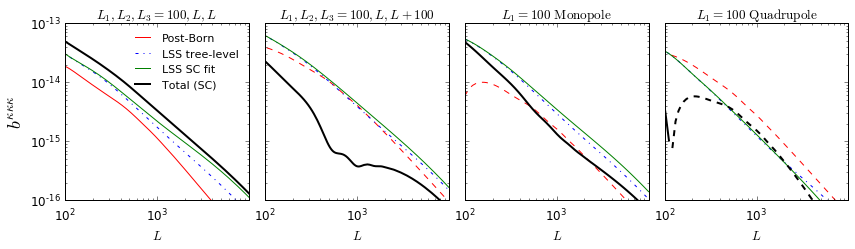

In [119]:
setPlotStyle()

litems =np.zeros((lsamp.size,3))
fig, axes = plt.subplots(1,4,figsize=(12,3.6), sharey=True, sharex=True)
l1=100
treestyle='-.'
for p,  ax in zip([0,1], axes):
    for i,l in enumerate(lsamp):
        if p==1:
            litems[i,:]=l1,l,l+l1
        else:
            litems[i,:]=l1,l,l            

    test=cl_bi(chistar,litems)
    test_SC=cl_bi(chistar,litems, fitsp=SC_fitsp)
    testborn = cl_bi_born(litems)

    ax.loglog(lsamp, -testborn, color='r',ls='--',label='_nolegend_')
    ax.loglog(lsamp, testborn, color='r',ls='-')
    ax.loglog(lsamp, test, color='b', ls=treestyle)
    ax.loglog(lsamp, test_SC, color='g')

    ax.loglog(lsamp, test_SC+testborn, color='k', ls='-', lw=2)
    ax.loglog(lsamp, -(test_SC+testborn), color='k', ls='--', lw=2,label='_nolegend_')
    if not p:
        ax.legend(['Post-Born','LSS tree-level','LSS SC fit', 'Total (SC)'], frameon =False)
    if p==1:
        ax.set_title('$L_1, L_2, L_3 = %s, L, L+%s$'%(l1,l1))
    else:
        ax.set_title('$L_1, L_2, L_3 = %s, L, L$'%(l1))
    ax.set_xlabel('$L$')
    
ax = axes[2]
p=axes[2].loglog
p(lplot,mom0, color='r', ls='-')
p(lplot,-mom0, color='r', ls='--',label='_nolegend_')

p(lplot,lssmom0, color='b', ls=treestyle)
p(lplot,lssSCmom0, color='g', ls='-')

p(lplot,lssmom0+mom0, color='k', ls='-', lw=2)
ax.set_xlabel('$L$')
ax.set_xlim([l1,1e4])
ax.set_ylim([1e-16,1e-13])
ax.set_title(r'$L_1=100 \,\, \rm{Monopole}$')

ax = axes[3]
p=axes[3].loglog
p(lplot,mom2, color='r', ls='-', nonposy='mask')
p(lplot,-mom2, color='r', ls='--',label='_nolegend_')

p(lplot,lssmom2, color='b', ls=treestyle)
p(lplot,lssSCmom2, color='g', ls='-')

p(lplot,lssmom2+mom2, color='k', ls='-', lw=2)
p(lplot,-(lssmom2+mom2), color='k', ls='--', lw=2)
ax.set_title(r'$L_1=100 \,\, \rm{Quadrupole}$')
ax.set_xlabel('$L$')
ax.set_xlim([l1,1e4])
ax.set_ylim([1e-16,1e-13])
ax.set_xticks([100,1000])
axes[0].set_ylabel('$b^{\kappa\kappa\kappa}$', fontsize=18);
fig.subplots_adjust(hspace=0)
fig.tight_layout(h_pad=0, w_pad=0)
#fig.savefig('Squeezed_L1_100.pdf', bbox_inches='tight')

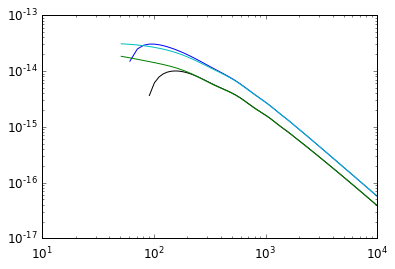

In [120]:
#Numerical vs squeezed
plt.loglog(lplot,-mom0, color='k', ls='-')
plt.loglog(lplot,-mom2, color='b', ls='-')
M0= -2*Mstarsp(l1,lplot, grid=False) + lplot*Mstarsp(lplot,l1,dx=1, grid=False)
M2= -2*Mstarsp(l1,lplot, grid=False)-2*Mstarsp(lplot,l1, grid=False)+lplot*Mstarsp(lplot,l1,dx=1, grid=False)

plt.loglog(lplot,-M0, color='g', ls='-')
plt.loglog(lplot,-M2,color='c',ls='-')


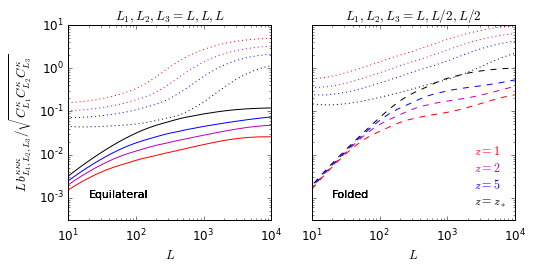

In [122]:
#Look at relative scaling of PB and LSS bispectra as function of redshift
#just have run worksheet saving files to the required z
nplot=2
fig,axs = plt.subplots(1,nplot,figsize=(4*nplot,3.5), sharey=True)
zstars = [1, 2, 5, 'star']
colrs = ['r','m','b','k']
#lsamp,testborn, test, test_SC, test_GM
for i, ax in enumerate(axs):
    for z, c in zip(zstars, colrs):
        kappa = np.loadtxt('kappa_20000_100_200_100_z%s.txt'%z)
        ck = UnivariateSpline(kappa[:,0],kappa[:,1], s=0)
        lscale=1
    #    plt.semilogx(equi[:,0],equi[:,1]/equi[:,3], color=c)
    #    plt.semilogx(folded[:,0],folded[:,1]/folded[:,3], ls='--', color=c, label='_nolegend_')
        if i==0:
            equi = np.loadtxt('equilateral_z%s.txt'%z)
            ax.loglog(equi[:,0],equi[:,0]**lscale*equi[:,1]/ck(equi[:,0])**1.5, color=c)
            ax.loglog(equi[:,0],equi[:,0]**lscale*equi[:,3]/ck(equi[:,0])**1.5, ls=':', color=c, label='_nolegend_')
            ax.set_title('$L_1,L_2,L_3 = L, L, L$')
            ax.text(20,1e-3,'Equilateral')
            ax.set_ylabel('$L\, b^{\kappa\kappa\kappa}_{L_1,L_2,L_3}/\sqrt{C^\kappa_{L_1}C^\kappa_{L_2}C^\kappa_{L_3}}$')
        elif i==1:            
            folded = np.loadtxt('folded_z%s.txt'%z)
            sigma = np.sqrt(ck(folded[:,0])*ck(folded[:,0]/2)**2)
            ax.loglog(folded[:,0],-folded[:,0]**lscale*folded[:,1]/sigma, ls='--',color=c, label='_nolegend_')
            ax.loglog(folded[:,0],folded[:,0]**lscale*folded[:,3]/sigma, ls=':', color=c)
            ax.text(20,1e-3,'Folded')
            ax.set_title('$L_1, L_2, L_3 = L, L/2, L/2$')
        elif i==2:            
            b = np.loadtxt('flattened123_z%s.txt'%z)
            sigma = np.sqrt(ck(b[:,0])*ck(b[:,0]*2)*ck(b[:,0]*3))
            ax.loglog(b[:,0],-b[:,0]**lscale*b[:,1]/sigma, ls='--',color=c, label='_nolegend_')
            ax.loglog(b[:,0],b[:,0]**lscale*b[:,3]/sigma, ls=':', color=c)
            ax.set_title('$L_1, L_2, L_3 = L, 2L, 3L$')
        elif i==3:            
            b = np.loadtxt('other122_z%s.txt'%z)
            sigma = np.sqrt(ck(b[:,0])*ck(b[:,0]*2)**2)
            ax.loglog(b[:,0],b[:,0]**lscale*b[:,1]/sigma, ls='-',color=c, label='_nolegend_')
            ax.loglog(b[:,0],b[:,0]**lscale*b[:,3]/sigma, ls=':', color=c)
            ax.set_title('$L_1, L_2, L_3 = L, 2L, 2L$')

    ax.set_xlim([10,1e4])
    ax.set_xlabel('$L$')
    ax.set_ylim([3e-4,10])
    if i: 
        for ix,(lab, c) in enumerate(zip(['$z = %s$'%z for z in zstars[:-1]]+['$z=z_*$'],colrs)):
            ax.text(2.5e3,1e-2/2.5**ix, lab, color=c, fontsize=12)
#fig.savefig('z_depend.pdf', bbox_inches='tight')

In [123]:
#Things for bispectrum contributions to C_BB. Main code in Fortran.
C = np.loadtxt(r'C:\Work\F90\LensingBiases\LensBias\LensPostBorn\LensPostBorn\base_plikHM_TT_lowTEB_lensing_lenspotentialCls.dat')
CE = C[:,2]/(C[:,0]**2)*2*np.pi
CEsp = UnivariateSpline(C[:,0],CE,s=0)

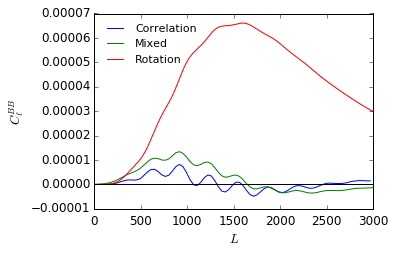

In [124]:
plt.figure(figsize=(5,3.5))
d=np.loadtxt(r'C:\Work\F90\LensingBiases\LensBias\LensPostBorn\LensPostBorn\CL_from_bi_mpi_4000_15_15_47.dat')
d2=np.loadtxt(r'C:\Work\F90\LensingBiases\LensBias\LensPostBorn\LensPostBorn\CL_mixed_bi_mpi_5000_15_15_47.dat')
plt.plot(d[:,0],d[:,0]*(d[:,0]+1)/2/np.pi*d[:,1])
plt.plot(d2[:,0],d2[:,0]*(d2[:,0]+1)/2/np.pi*d2[:,1])

fac=lsamp*(lsamp+1)/2/np.pi
sp = UnivariateSpline(lsamp, fac*Bcurl2, s=0)
lsp = np.arange(lsamp[0],lsamp[-1])
plt.plot(lsp, sp(lsp))
#plt.plot(lsamp,fac*Bcurl2)
plt.xlim([2,3000])
plt.axhline(0,color='k')
plt.legend(['Correlation','Mixed','Rotation'], loc='upper left', frameon=False)
plt.xlabel('$L$')
plt.ylabel('$C_\ell^{BB}$')
#plt.yscale('symlog')
corrsp = UnivariateSpline(d[:,0], d[:,1])
corrsp = UnivariateSpline(d2[:,0], d2[:,1])


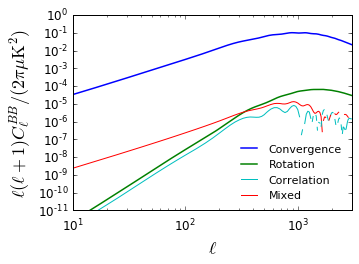

In [125]:
fig=plt.figure(figsize=(5,3.5))
plt.loglog(lsamp,fac*Bphi,color='b', lw=1.5)
plt.loglog(lsamp,fac*Bcurl2, color='g', lw=1.5)

plt.loglog(d[:,0],d[:,0]*(d[:,0]+1)/2/np.pi*d[:,1], color='c')
plt.loglog(d2[:,0],d2[:,0]*(d2[:,0]+1)/2/np.pi*d2[:,1], color='r')

plt.loglog(d[:,0],-d[:,0]*(d[:,0]+1)/2/np.pi*d[:,1], ls='--', color='c')
plt.loglog(d2[:,0],-d2[:,0]*(d2[:,0]+1)/2/np.pi*d2[:,1], color='r', ls='--')
plt.xlim([10,3000])
plt.ylim([1e-11,1])

plt.legend(['Convergence','Rotation','Correlation','Mixed'], loc='lower right', frameon=False)
plt.xlabel('$\ell$', fontsize=18)
plt.ylabel(r'$\ell(\ell+1)C_\ell^{BB}/(2\pi \mu\rm{K}^2)$', fontsize=18);
#fig.savefig('BB_bispectrum_terms.pdf', bbox_inches='tight')